# Interpretation Challenges

# 

In this chapter, using flight delay and cancellation data, you will learn about the traditional methods used for machine learning interpretation for both regression and classification. There are model performance evaluation methods such as RMSE, R-squared, AUC, ROC Curves, and the many metrics derived from confusion matrices. On the other hand, there are several dimensionality reduction visualization techniques we will explore. We will examine the limitations of these traditional methods. Then, study models that are intrinsically interpretable (also known as white-box) such as Linear Regression, CART decision trees, Naive Bayes, KNN, and Logistic Regression. Then discuss the trade-off between prediction performance and model interpretability. Finally, we will discover some new “glass-box” models such as EBM and Skoped Rules that attempt not to compromise in this trade-off. These are the main topics we are going to cover:

- Traditional Model Interpretation Methods
- Limitations of Traditional Model Interpretation Methods
- Intrinsically interpretable models (White-box)
- Performance vs Interpretability Trade-off
- Newer Interpretable Models (Glass-box)

## Technical Requirements

!!! From Chapter 2 (_Key Concepts of Interpretability_) onwards, we are using a custom  `mldatasets` library to load our datasets. Instructions on how to install this library are located in the preface. These instructions are in the preface. In addition to `mldatasets`, this chapter's examples also uses `pandas`, `numpy`, `sklearn`, `rulefit`, `cvae`, `interpret`, `statsmodels`, `matplotlib` and `skoped-rules` libraries. The code for this chapter is located here: `https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/Chapter3/`!!!

## Traditional Model Interpretation Methods

!!!Picture yourself, a data science consultant, in a conference room in Forth Worth, Texas, and it's early January 2019. In this conference room, executives for one of the world's largest airlines, American Airlines, are briefing you on their OTP (on-time performance). OTP is a widely accepted key performance indicator for flight punctuality. It is measured as a percentage of flights that arrived within 15 minutes of scheduled arrival. It turns out American Airlines (AA) has achieved an OTP of just over 80% for three years in a row, which is already acceptable, and much better than before, but they are still 9th in the world and 5th in North America. To brag about it next year in their advertising, they aspire to achieve, at least, number one in North America for 2019, besting their biggest rivals. On the financial front, it is estimated that delays cost the airline close to $\$2$ billion, so reducing this by even $25-35\%$ to be on parity with their competitors could produce sizable savings. And it is estimated that passengers foot the bill at least as significant due to tens of millions of lost time hours. A reduction in delays would produce happier customers, which could lead to an increase in ticket sales.!!!

Your task is to create models that can predict delays for domestic flights only. What they hope to gain from the models is:

1) Understand what factors impacted arrival delays the most in 2018. 

2) Anticipate an arrival delay mid-air with enough accuracy to mitigate these factors in 2019.

!!!But not all delays are made equal. International Air Transport Association (IATA) has over 80 delay codes ranging from 14 (_Oversales, booking errors_) to 75 (_De-Icing of aircraft, removal of ice/snow, frost prevention_). Some are preventable, and others unavoidable. The airline is not interested in predicting delays caused by events out of their control, such as extreme weather, security events, and air traffic control issues. They are also not interested in delays caused by late arrivals from previous flights using the same aircraft because this was not the root cause. However, executives cautioned you that delays involving hub airports could have a significant _knock-on effect_ including _rotational delays_ such as delaying more flights like connecting flights and those scheduled to use the same aircraft. They are well aware of what airports have most delays and, to some degree why. Nevertheless, they would like to know the effect of a busy hub on avoidable delays even if this has to do with congestion because, after all, perhaps there's something they can do with flight scheduling or flight speed, or even gate selection. And while they understand that international flights occasionally impact domestic flights, they hope to tackle the sizeable local market first.!!!

Executives have provided you with a dataset from the United States Department of Transportation _Bureau of Transportation Statistics_ with all 2018 AA domestic flights. Now, let's take a look at the dataset!

### American Airlines Domestic Delay Data, 2018

Let's examine the data dictionary.

!!!General features:

- **FL_NUM**: Flight number
- **ORIGIN**: Starting airport code (IATA)
- **DEST**: Destination airport code (IATA)

Departure features:

- **PLANNED_DEP_DATETIME**: Planned date and time of the flight
- **CRS_DEP_TIME**: Planned departure time
- **DEP_TIME**: Actual departure time
- **DEP_AFPH**: Number of actual flights per hour occurring during the interval in between planned and actual departure at the origin airport (factoring 30 minutes of padding). The feature tells you how busy the origin airport was during takeoff. 
- **DEP_RFPH**: Departure relative flights per hour is the ratio of actual flights per hour over the median amount of flights per hour that occurs at the origin airport that time of day, day of the week, and month of the year. The feature tells you how _relatively_ busy the origin airport was during takeoff. 
- **TAXI_OUT**: The time duration elapsed between departure from the origin airport gate and wheels off
- **WHEELS_OFF**: The time point that the aircraft's wheels leave the ground

In-flight features:

- **CRS_ELAPSED_TIME**: Planned time amount needed for the flight trip.
- **PCT_ELAPSED_TIME**: Ratio of actual flight time over planned flight time to gauge the plane's relative speed. 
- **DISTANCE**: Distance between two airports.

Arrival features:

- **CRS_ARR_TIME**: Planned arrival time
- **ARR_AFPH**: Number of actual flights per hour occurring during the interval between the planned and actual arrival at the destination airport (factoring 30 minutes of padding). The feature tells you how busy the destination airport was during landing. 
- **ARR_RFPH**: Arrival relative flights per hour is the ratio of actual flights per hour over the median amount of flights per hour that occurs at the destination airport that time of day, day of the week, and month of the year. The feature tells you how _relatively_ busy the destination airport was during landing. 

Delay features:

- **DEP_DELAY**: Total delay on departure in minutes.
- **ARR_DELAY**: Total delay on arrival in minutes can be subdivided by any or all of the following:
- **CARRIER_DELAY**: Delay in minutes caused by circumstances within the airline's control (e.g., maintenance or crew problems, aircraft cleaning, baggage loading, fueling, etc.).
- **WEATHER_DELAY**: Delay in minutes caused by significant meteorological conditions (actual or forecasted). 
- **NAS_DELAY**: Delay in minutes mandated by a national aviation system such as non-extreme weather conditions, airport operations, heavy traffic volume, and air traffic control.
- **SECURITY_DELAY**: Delay in minutes caused by evacuation of a terminal or concourse, re-boarding of aircraft because of a security breach, faulty screening equipment, or long lines above 29 minutes screening areas.
- **LATE_AIRCRAFT_DELAY**: Delay in minutes caused by a previous flight with the same aircraft arrived which late.!!!

???Also, since they aren't interested so much in examining individual airports or the flights scheduled to and from them, you can ignore the columns with IATA codes and flight codes. From the looks of it, there's quite a bit of feature engineering to perform on this dataset. And as we will learn in Chapter 10 (_Feature Engineering and Selection for Interpretability_), this is a crucial step in making sure that machine learning model results are not only accurate but interpretable.???

Upon careful consideration, you have decided to approach this both as a regression problem and a classification problem. You are producing models that predict minutes delayed as well as models that classify if delayed or not. For interpretation, using both, will enable you to use a wider variety of methods, and expand your interpretation accordingly. So we will approach this example in the followings steps:

- Data Preparation
- Predicting Flight Minutes Delayed with Various Regression Methods
- Classifying Flights as Delayed or Not Delayed with Various Classification Methods
- Visualizing Delayed Flights with Dimensionality Reduction Methods

These steps are followed by conclusions spread out in the rest of the sections of this chapter.

### Data Preparation

!!!You will find the code for this example here: https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/tree/master/Chapter3/Example1.ipynb !!!

To run this example, you need to install the following libraries:

!!!
- `mldatasets` to load the dataset
- `pandas` and `numpy` to manipulate it
- `sklearn` (Scikit-learn), `rulefit`, `cvae`, `statsmodels`, `interpret` and `skoped-rules` to fit models and calculate performance metrics. 
- `matplotlib` and `seaborn` to create visualizations!!!

You should load all of them first:

In [1]:
#TODO remove
import warnings
import pandas as pd
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [2]:
import math
import mldatasets
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model, tree, naive_bayes, neighbors, ensemble,\
                    neural_network, svm, decomposition, manifold
from rulefit import RuleFit
import statsmodels.api as sm
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC
import matplotlib.pyplot as plt
import seaborn as sns

At the time of writing, two libraries, Compression VAE (`cvae`) and SkopedRules (`skrules`), have some minor incompatibilities with recent versions of other libraries. Still, they can be easily resolved so you should load them as such:

In [3]:
import sys
#Next two lines of code only needed while CVAE 
#remains incompatible to Tensorflow 2.2+
import tensorflow.compat.v1 as tf
sys.modules['tensorflow'] = tf
from cvae import cvae
#Next two lines of code only needed while SkopedRules
#remains incompatible to Sklearn 0.23.0+
import six
sys.modules['sklearn.externals.six'] = six
from skrules import SkopeRules

Then we load the data like this:

In [4]:
aad18_df = mldatasets.load("aa-domestic-delays-2018")

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/aa-domestic-delays-2018.csv.zip downloaded to /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter3/data/aa-domestic-delays-2018.csv.zip
/Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter3/data/aa-domestic-delays-2018.csv.zip uncompressed to /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter3/data/aa-domestic-delays-2018.csv
1 dataset files found in /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter3/data/aa-domestic-delays-2018.csv folder
parsing /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter3/data/aa-domestic-delays-2018.csv/aa-domestic-delays-2018.csv


There should be nearly 900 thousand records and 23 columns. We can take a peak at what was loaded like this:

In [5]:
aad18_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899527 entries, 0 to 899526
Data columns (total 23 columns):
FL_NUM                  899527 non-null int64
ORIGIN                  899527 non-null object
DEST                    899527 non-null object
PLANNED_DEP_DATETIME    899527 non-null object
CRS_DEP_TIME            899527 non-null int64
DEP_TIME                899527 non-null float64
DEP_DELAY               899527 non-null float64
DEP_AFPH                899527 non-null float64
DEP_RFPH                899527 non-null float64
TAXI_OUT                899527 non-null float64
WHEELS_OFF              899527 non-null float64
CRS_ELAPSED_TIME        899527 non-null float64
PCT_ELAPSED_TIME        899527 non-null float64
DISTANCE                899527 non-null float64
CRS_ARR_TIME            899527 non-null int64
ARR_AFPH                899527 non-null float64
ARR_RFPH                899527 non-null float64
ARR_DELAY               899527 non-null float64
CARRIER_DELAY           899527 non

!!!Everything seems to be in order because all columns are there and there are no null values. However, `PLANNED_DEP_DATETIME` must be a datetime date type:

In [6]:
aad18_df['PLANNED_DEP_DATETIME'] = pd.to_datetime(aad18_df['PLANNED_DEP_DATETIME'])

The exact day and time of a flight doesn't matter, but maybe the month and day of the week because of weather and seasonal patterns that can only be appreciated at this level of granularity. Therefore, we will create features for the month and day of the week:

In [7]:
aad18_df['DEP_MONTH'] = aad18_df['PLANNED_DEP_DATETIME'].dt.month
aad18_df['DEP_DOW'] = aad18_df['PLANNED_DEP_DATETIME'].dt.dayofweek

We don't need the `PLANNED_DEP_DATETIME` column so let's drop it like this:

In [8]:
aad18_df = aad18_df.drop(['PLANNED_DEP_DATETIME'], axis=1)

It is essential to register is if the arrival or destination airport is a hub. American Airlines, in 2019, had ten hubs: Charlotte, Chicago–O'Hare, Dallas/Fort Worth, Los Angeles, Miami, New York–JFK, New York–LaGuardia, Philadelphia, Phoenix–Sky Harbor and Washington–National. Therefore, we can encode which `ORIGIN` and `DEST` airports are American Airlines hubs, and get rid of columns with codes since they are too specific (`FL_NUM`, `ORIGIN` and `DEST`):

In [9]:
#Create list with 10 hubs
hubs = ['CLT', 'ORD', 'DFW', 'LAX', 'MIA', 'JFK', 'LGA', 'PHL', 'PHX', 'DCA']
#Boolean series for if ORIGIN or DEST are hubs
is_origin_hub = aad18_df['ORIGIN'].isin(hubs)
is_dest_hub = aad18_df['DEST'].isin(hubs)
#Use boolean series to set ORIGIN_HUB and DEST_HUB
aad18_df['ORIGIN_HUB'] = 0
aad18_df.loc[is_origin_hub, 'ORIGIN_HUB'] = 1
aad18_df['DEST_HUB'] = 0
aad18_df.loc[is_dest_hub, 'DEST_HUB'] = 1
#Delete columns with codes
aad18_df = aad18_df.drop(['FL_NUM', 'ORIGIN', 'DEST'], axis=1)

After all these operations we have a fair amount of useful features, but we have yet to determine the target feature. There are two columns that could serve this purpose. We have `ARR_DELAY`, which is the total amount of minutes delayed regardless of the reason, and then there's `CARRIER_DELAY`, which is just the total amount of those minutes that can be attributed to the airline. For instance, look at the following sample of flights delayed over 15 minutes (which is considered late according to the airline's definition):

In [10]:
aad18_df.loc[aad18_df['ARR_DELAY'] > 15, ['ARR_DELAY','CARRIER_DELAY']].head(10)

,ARR_DELAY,CARRIER_DELAY
8,168.000000,136.000000
16,20.000000,5.000000
18,242.000000,242.000000
19,62.000000,62.000000
22,19.000000,19.000000
26,26.000000,0.000000
29,77.000000,77.000000
32,19.000000,19.000000
33,18.000000,1.000000
40,36.000000,16.000000


![png](./Chapter3_files_extra/Fig_02.png)
##### *Figure 1: One of them (#26) wasn't at all the responsibility of the airline. Four of them were partially the responsibility of the airline (#8, #16, #33, #40), two of which were over 15 minutes late due to the airline (#8, #40). The rest of them were entirely the airline's fault.*

Although the total delay is useful information, the airline executives were only interested in delays caused by the airline so `ARR_DELAY` can be discarded. Furthermore, there's another more important reason it should be discarded, and it's that if the task at hand is to predict a delay, we cannot use pretty much the very same delay (minus the portions not due to the airline) to predict it. This would be **like using today's newspaper slightly redacted to predict today's news**. For this very same reason, it is best to remove `ARR_DELAY`:

In [11]:
aad18_df = aad18_df.drop(['ARR_DELAY'], axis=1)

Finally, we put the target feature alone as the `y` and all the rest as the `X`. After this, we split the `y` and `X` in train and test datasets. Please note that the target feature (`y`) stays the same for regression so we split it to `y_train_reg` and `y_test_reg`. However, for classification we must make binary versions of these based on whether it's more than 15 minutes late or not, called `y_train_class` and `y_test_class`. Please note that we are setting a fixed `random_state` for reproducibility.

In [12]:
rand = 9
y = aad18_df['CARRIER_DELAY']
X = aad18_df.drop(['CARRIER_DELAY'], axis=1).copy()
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.15, random_state=rand)
y_train_class = y_train_reg.apply(lambda x: 1 if x > 15 else 0)
y_test_class = y_test_reg.apply(lambda x: 1 if x > 15 else 0)

To examine how linearly correlated the features are to the target `CARRIER_DELAY` we compute _Pearson's correlation coefficient_, turn coefficients to absolute values (because we aren't interested if they are positively or negatively correlated) and sort them in descending order:

In [13]:
corr = aad18_df.corr()
abs(corr['CARRIER_DELAY']).sort_values(ascending=False)

CARRIER_DELAY         1.000000
DEP_DELAY             0.703935
ARR_RFPH              0.101742
LATE_AIRCRAFT_DELAY   0.083166
DEP_RFPH              0.058659
ARR_AFPH              0.035135
DEP_TIME              0.030941
NAS_DELAY             0.026792
WHEELS_OFF            0.026787
TAXI_OUT              0.024635
PCT_ELAPSED_TIME      0.020980
CRS_DEP_TIME          0.016032
ORIGIN_HUB            0.015334
DEST_HUB              0.013932
DISTANCE              0.010680
DEP_MONTH             0.009728
CRS_ELAPSED_TIME      0.008801
DEP_DOW               0.007043
CRS_ARR_TIME          0.007029
DEP_AFPH              0.006053
WEATHER_DELAY         0.003002
SECURITY_DELAY        0.000460
Name: CARRIER_DELAY, dtype: float64

As you can tell, only one feature (`DEP_DELAY`) is highly correlated. The others aren't. However, this is only linearly and on a one by one basis. It doesn't mean that they don't have a non-linear relationship, or several features interacting together wouldn't impact the target. In the next section, we will discuss this further.

### Predicting Flight Minutes Delayed with Various Regression Methods

To compare and contrast regression methods, we will first create a dictionary named `reg_models`. Each model is it's own dictionary and the function that creates it in the `model` attribute. This structure will be used later to store the fitted model neatly, and it's metrics. Model classes in this dictionary have been chosen to represent several model families and to illustrate important concepts that we will discuss later.

In [14]:
reg_models = {
        #Generalized Linear Models (GLMs)
        'linear':{'model': linear_model.LinearRegression()}, 
        'linear_poly':{'model': make_pipeline(PolynomialFeatures(degree=2),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'linear_interact':{'model': make_pipeline(PolynomialFeatures(interaction_only=True),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'ridge':{'model': linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]) }, 
        #Trees  
        'decision_tree':{'model': tree.DecisionTreeRegressor(max_depth=7, random_state=rand)},
        #RuleFit
        'rulefit':{'model': RuleFit(max_rules=150, rfmode='regress', random_state=rand)}, 
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsRegressor(n_neighbors=7)}, 
        #Ensemble Methods
        'random_forest':{'model':ensemble.RandomForestRegressor(max_depth=7, random_state=rand)}, 
        #Neural Networks
        'mlp':{'model':neural_network.MLPRegressor(hidden_layer_sizes=(21,), max_iter=500, 
                                                   early_stopping=True, random_state=rand)}
    }

Before we start fitting the data to these models, we will briefly explain them one by one:

- **`linear`**: _Linear Regression_ was the first model class we discussed. For better or for worse, it makes several assumptions about the data. Chief among them is the assumption that the $y$ prediction must be a linear combination of $X$ features. This, naturally, limits the capacity to discover non-linear relationships and interactions among the features.
- **`linear_poly`**: _Polynomial Regression_ extends Linear Regression by adding polynomial features. In this case, as indicated by `degree=2`, the polynomial degree is two, so it's quadratic. This means, in addition to having all features in their monomial form (e.g., $\text{DEP_FPH}$), it also has them in a quadratic form (e.g., $\text{DEP_FPH}^2$) plus the many interaction terms for all of the 21 features. In other words, for $\text{DEP_FPH}^2$, there would be interaction terms like $\text{DEP_FPH} \times \text{DISTANCE}$, $\text{DEP_FPH} \times \text{DEP_DELAY}$, and so on for the rest of the features.
- **`linear_interact`**: Just like the polynomial regression model but without the quadratic terms. In other words, only the interactions as the `interaction_only=True` would suggest. It's useful because there is no reason to believe any of our features have a relationship that is better fitted with quadratic terms. Still, perhaps it's the interaction with other features that makes an impact.
- **`ridge`**: _Ridge Regression_ is a variation of Linear Regression. However, even though the method behind linear regression, called _Ordinary Least Squares_, does a pretty good job in reducing the error, fitting the model to the features, it does it without considering _overfitting_. The problem here is that OLS treats all features equally, so the model becomes more complex as each variable is added. As the word, _overfitting_ suggests the resulting model fits the training data too well, resulting in the lowest bias but the highest variance. There's a sweet spot in this trade-off between _bias_ and _variance_, and one way of getting to this spot is reducing complexity added by the introduction of too many features. Linear Regression is not equipped in doing on its own. This is where Ridge Regression comes along with our friend, _regularization_. It does this by shrinking coefficients that don't contribute to the outcome with a penalty term called the _L2 norm_. In this example, we use a cross-validated version of Ridge (`RidgeCV`) that tests several regularization strengths (`alphas`). 
- **`decision_tree`**: a _Decision Tree_ is as precisely as the name suggests. Imagine a tree line structure where at every point where branches subdivide to form more branches, there is a "test" performed on a feature partitioning the datasets into each branch. When branches stop subdividing, they become leaves, and at every leaf, there's _a decision_ be it assign a _class_ for classification or fixed value for regression. We are limiting this tree to `max_depth=7` to prevent overfitting.
- **`rule_fit`**: RuleFit is a regularized linear regression expanded to include feature interactions in the form of rules. The rules are formed by traversing a decision tree, except it discards the leaves and keeps the feature interactions found traversing the branches towards these leaves. It uses Lasso regression, which like Ridge, uses regularization, but instead of using the _L2 norm_, it uses the _L1 norm_. The result is that useless features end up with a coefficient of zero and not just converge to zero. We are limiting the rules to 150 (`max_rules=150`) and the attribute `rfmode='regress'` tells RuleFit that this is a regression problem, since it can also be used for classification. Unlike all other models used here, this isn't a sci-kit learn one, but created by Christoph Molnar adapting a paper [[^1]]. 
- **`knn`**: _k-Nearest Neighbors_ a simple method based on the _locality_ assumption, which is that data points that are close to each other are similar. In other words, they must have similar predicted values, and, in practice, this isn't a bad guess, so it takes $k$ data points nearest to the point you want to predict and derives a prediction based on that. In this case, `n_neighbors=7` so $k=7$. It's an _instance-based_ machine learning techniques, also known as _lazy learner_ because it simply stores the training data and, in inference, uses it to calculate the similarity with points and generate a prediction based on that. This is opposed to what model-based machine learning techniques, or _eager learners_, do, which is to leverage training data to learn formulas, parameters, coefficients, or bias/weights which it for inference can use to make a prediction.
- **`random_forest`**: Imagine not one but hundreds of decision trees trained on random combinations of the features and random samples of the data.  _Random Forest_ takes an average of these randomly generated decision trees to create the best tree. This concept of training less effective models in parallel and combining them using an averaging process is called _bagging_. It is an _ensemble_ method because it combines more than one model (usually called _weak learners_) into a _strong learner_. In addition to _bagging_, there are two other ensemble techniques called _boosting_ and _stacking_. For bagging deeper, trees are better because they reduce variance, so this why we using `max_depth=7`.
- **`mlp`**: _Multi-layer perceptron_ is a "vanilla" feed-forward (sequential) neural network, so it uses non-linear activation functions (`MLPRegressor` uses _relu_ by default), stochastic gradient descent and backpropagation. In this case, we are using 21 neurons in the first and only hidden layer hence `hidden_layer_sizes=(21,)`, running training for 500 epochs (`max_iter=500`) and terminate training when validation score is not improving (`early_stopping=True`).

[^1]: Friedman, J., & Popescu, B. (2008). Predictive Learning via Rule Ensembles. The Annals of Applied Statistics, 2(3), 916-954. Retrieved July 1, 2020, from `http://doi.org/10.1214/07-AOAS148`

If you are unfamiliar to some of these models, don't fret! We will cover them in more detail either later in this chapter, or the book. Also, please note that some of these models have a random process somewhere. To ensure reproducibility, we have set the `random_state`. It would be best if you strived to always set these because otherwise, it will randomly set it every single time, which will make your results hard to reproduce.  

Now, let's iterate over our dictionary of models (`reg_models`), fit them to the training data, predict and compute two metrics based on the quality of these predictions. We then save the fitted model, test predictions, and metrics in the dictionary for later use. Note that `rulefit` only accepts `numpy` arrays, so we can't `fit` it in the same way. Also, note `rulefit` and `mlp` take longer than the rest to train, so this can take a few minutes to run. 

In [15]:
for model_name in reg_models.keys():
    if model_name != 'rulefit':
        fitted_model = reg_models[model_name]['model'].fit(X_train, y_train_reg)
    else:
        fitted_model = reg_models[model_name]['model'].fit(X_train.values, y_train_reg.values, X_test.columns)
    y_train_pred = fitted_model.predict(X_train.values)
    y_test_pred = fitted_model.predict(X_test.values)
    reg_models[model_name]['fitted'] = fitted_model
    reg_models[model_name]['preds'] = y_test_pred
    reg_models[model_name]['RMSE_train'] = math.sqrt(metrics.mean_squared_error(y_train_reg, y_train_pred))
    reg_models[model_name]['RMSE_test'] = math.sqrt(metrics.mean_squared_error(y_test_reg, y_test_pred))
    reg_models[model_name]['R2_test'] = metrics.r2_score(y_test_reg, y_test_pred)

We can now convert the dictionary to a dataframe and display the metrics in a sorted and color-coded fashion:

In [ ]:
reg_metrics = pd.DataFrame.from_dict(reg_models, 'index')[['RMSE_train', 'RMSE_test', 'R2_test']]
reg_metrics.sort_values(by='RMSE_test').style.\
    background_gradient(cmap='viridis', low=1, high=0.3, subset=['RMSE_train', 'RMSE_test']).\
    background_gradient(cmap='plasma', low=0.3, high=1, subset=['R2_test'])

![png](./Chapter3_files_extra/Fig_03.png)
##### *Figure 3: Regression metrics for our models.*

To interpret the metrics, we ought to first understand what they mean, both in general as well as in the context of this regression exercise:

- **RMSE**: _Root Mean Square Error_ is defined as the standard deviation of the residuals. It's the square root of the squared residuals divided by the number of observations, in this case, flights. It tells you, on average, how far apart the predictions are from the actuals, and as you can probably tell from the color coding, less is better because you want your predictions to be as close as possible to the actuals in the _test_ (_hold-out_) dataset. We have also included this metric for the _train_ dataset to see how well it's generalizing. You expect the test error to be higher than the training error, but not by much. If it is, like it is for `random_forest`, you need to tune some of the parameters. In this case, reducing the trees' maximum depth, increasing the number of trees (also called _estimators_), and reducing the maximum number of features to use should do the trick. On the other hand, with `knn`, you can adjust the $k$, but it is expected because of its _lazy learner_ nature to overperform on the training data. In any case, these numbers are pretty good because even our worst performing model is below a test RMSE of 10, and about half of them have a test RMSE of less than 7.5 quite possibly predicting a delay effectively, on average, since the threshold for a delay is 15 minutes. 
- **$R^2$**: _R squared_ is also known as the _coefficient of determination_. It's defined as the proportion of the variance in the $y$ (outcome) target that can be explained by the $X$ (predictor) features in the model. It answers the question of what is the variability explained by the model as a proportion of all of it? And as you can probably tell from the color coding, more is better. And our models appear to include significant $X$ features, as evidenced, by our _Pearson's correlation coefficients_. So if this $R^2$ value was low perhaps adding additional features would help such as flight logs, terminal conditions, and even those things airline executives said they weren't interested in exploring right now such as _knock-off_ effects and international flights. These could fill in the gaps in the unexplained variance.

Let's see if we can get good metrics with classification.

### Classifying Flights as Delayed or Not Delayed with Various Classification Methods

Just as we did with regression, to compare and contrast classification methods, we will first create a dictionary for them named `class_models`. Each model is it's own dictionary and the function that creates it in the `model` attribute. This structure will be used later to store the fitted model neatly, and it's metrics. Model classes in this dictionary have been chosen to represent several model families and to illustrate important concepts that we will discuss later. Some of these will look familiar because they are the same methods used in regression but applied to classification.

In [17]:
class_models = {
        #Generalized Linear Models (GLMs)
        'logistic':{'model': linear_model.LogisticRegression()}, 
        'ridge':{'model': linear_model.RidgeClassifierCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1],\
                                                         class_weight='balanced')},  
        #Tree
        'decision_tree':{'model': tree.DecisionTreeClassifier(max_depth=7, random_state=rand)},
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsClassifier(n_neighbors=7)}, 
        #Naive Bayes
        'naive_bayes':{'model': naive_bayes.GaussianNB()},
        #Ensemble Methods
        'gradient_boosting':{'model':ensemble.GradientBoostingClassifier(n_estimators=210)},
        'random_forest':{'model':ensemble.RandomForestClassifier(max_depth=11,\
                                                                 class_weight='balanced', random_state=rand)},
        #Neural Networks
        'mlp':{'model':make_pipeline(StandardScaler(),\
                                     neural_network.MLPClassifier(hidden_layer_sizes=(7,), max_iter=500,\
                                                   early_stopping=True, random_state=rand))}
    }

Before we start fitting the data to these models, we will briefly explain them one by one:

- **`logistic`**: _Logistic Regression_ was introduced in Chapter 2 (_Key Concepts of Interpretability_). It has many of the same pros and cons as _Linear Regression_. For instance, feature interactions must be added manually. Like other classification models, it returns a probability between $0$ and $1$ which, when closer to $1$ denote a probable match to a _positive class_ while when closer to $0$, an improbable match to the _positive class_, and therefore a probable match to the _negative class_. Naturally, $0.5$ is the threshold used to decide between classes, but it doesn't have to be. As we will examine later in the book, there are interpretation and performance reasons to adjust the threshold. Note that this is a binary classification problem, so we are only choosing between delayed (positive) and not delayed (negative), but this method could be extended to multi-class classification. It would then be called _Multinomial Classification_.
- **`ridge`**: _Ridge Classification_ leverages the same regularization technique used in _Ridge regression_ but applied to classification. It does this by converting the target values as $-1$ (for negative class) and keeping $1$ for positive class and then performing _Ridge Regression_. At its heart, its regression in disguise will predict values between $-1$ and $1$, and then convert them back to $0-1$ scale. Like with `RidgeCV` for regression, `RidgeClassifierCV` uses a leave-one-out cross-validation which means it first splits the data into different equal size sets - in this case, we are using five sets (`cv=5`) - and then removes features one at a time to see how well the model performs without them, on average in all the five sets. Those features that don't make much of a difference are penalized testing several regularization strengths (_alphas_) to find the optimal strength. As with all _regularization_ techniques, the point is to discourage learning from unnecessary complexity, minimizing the impact of less salient features. 
- **`decision_tree`**: A "vanilla" _Decision Tree_, such as this one, is also known as CART (_Classification And Regression Tree_) because it can be used for regression or classification tasks. It has the same architecture for both tasks but functions slightly differently, like the procedure used to decide where to "split" a branch. In this case, we are only allowing our trees to have a depth of 7 (`max_depth=7`).
- **`knn`**: _k-Nearest Neighbors_ can also be applied to classification tasks except instead of averaging what the nearest neighbors' target features (or labels) are, it chooses the most frequent one (also known as the _mode_). We are also using a $k$ of 7 for classification.
- **`naive_bayes`**: _Gaussian Naïve Bayes_ is part of the family of _Naïve Bayes_ classifiers, which are called naïve because like they make some assumptions that the features are independent of each other, which is usually not the case. This dramatically impedes its capacity to predict unless the assumption is correct. It's called _Bayes_ because it's based on _Bayes' theorem of conditional probabilities_, which is that the conditional probability of a class is the class probability times the feature probability given the class. _Gaussian Naïve Bayes_ makes an additional assumption, which is that continuous values have a normal distribution, also known as a _Gaussian distribution_.
- **`gradient_boosting`**: Like _Random Forest_, _Gradient Boosted Trees_ are also an ensemble method, but that leverages _boosting_ instead of _bagging_. Boosting doesn't work in parallel but in sequence iteratively training weak learners and incorporating their strengths into a stronger learner, while adapting another weak learner to tackle their weaknesses. Although ensembles and boosting, in particular, can be done with a model class, this one uses decision trees. We have limited the number of trees to 210 (`n_estimators=210`).
- **`random_forest`**: The same _Random Forest_ as with regression except it uses classification decision trees and not regression trees. 
- **`mlp`**: Same _Multi-layer perceptron_ as with regression, but the output layer, by default, uses _logistic_ function in the output layer to yield probabilities, which it then converts to $1$ or $0$, based on the $0.5$ threshold. Another difference is that we are using seven neurons in the first and only hidden layer (`hidden_layer_sizes=(7,)`) because binary classification tends to require less of them to achieve an optimal result.

Please note that some of these models use balanced weights for the classes (`class_weight='balanced'`), which is very important because this happens to an _imbalanced classification_ task. By that, we mean that negative classes vastly outnumber positive classes. You can find out what this looks like for our training data:

In [18]:
y_train_class[y_train_class==1].shape[0] / y_train_class.shape[0]

0.061283264255549

In our training data, positive classes represent only 6% of the total. Models that account for this will achieve _fairer_ results. There are different ways for accounting for _class imbalance_, which we will discuss in further detail in Chapter 11 (_Mitigating the Influence of Bias in Datasets_) but `class_weight='balanced'` applies a weight inversely proportional to class frequencies given the outnumbered _positive_ class a leg up.

Now, let's iterate over our dictionary of models (`class_models`), fit them to the training data, and predict both probabilities and predicted class except for `ridge`, which doesn't output probabilities. We then compute five metrics based on the quality of these predictions. Lastly, we save the fitted model, test predictions, and metrics in the dictionary for later use. You can go get a coffee while you run the next snippet of code because `gradient_boosting` takes longer than the rest to train, so this can take a few minutes to run.

In [19]:
for model_name in class_models.keys():
    fitted_model = class_models[model_name]['model'].fit(X_train, y_train_class)
    y_train_pred = fitted_model.predict(X_train.values)
    if model_name == 'ridge':
        y_test_pred = fitted_model.predict(X_test.values) 
    else:
        y_test_prob = fitted_model.predict_proba(X_test.values)[:,1]
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['probs'] = y_test_prob
    class_models[model_name]['preds'] = y_test_pred
    class_models[model_name]['Accuracy_train'] = metrics.accuracy_score(y_train_class, y_train_pred)
    class_models[model_name]['Accuracy_test'] = metrics.accuracy_score(y_test_class, y_test_pred)
    class_models[model_name]['Recall_train'] = metrics.recall_score(y_train_class, y_train_pred)
    class_models[model_name]['Recall_test'] = metrics.recall_score(y_test_class, y_test_pred)
    if model_name != 'ridge':
        class_models[model_name]['ROC_AUC_test'] = metrics.roc_auc_score(y_test_class, y_test_prob)
    else:
        class_models[model_name]['ROC_AUC_test'] = 0
    class_models[model_name]['F1_test'] = metrics.f1_score(y_test_class, y_test_pred)
    class_models[model_name]['MCC_test'] = metrics.matthews_corrcoef(y_test_class, y_test_pred)

We can now convert the dictionary to a dataframe and display the metrics in a sorted and color-coded fashion:

In [ ]:
class_metrics = pd.DataFrame.from_dict(class_models, 'index')[['Accuracy_train', 'Accuracy_test',\
                                                               'Recall_train', 'Recall_test',\
                                                               'ROC_AUC_test', 'F1_test', 'MCC_test']]
class_metrics.sort_values(by='ROC_AUC_test', ascending=False).style.\
    background_gradient(cmap='plasma', low=0.3, high=1, subset=['Accuracy_train', 'Accuracy_test']).\
    background_gradient(cmap='viridis', low=1, high=0.3, subset=['Recall_train', 'Recall_test',\
                                                                 'ROC_AUC_test', 'F1_test', 'MCC_test'])

![png](./Chapter3_files_extra/Fig_04.png)
##### *Figure 4: Classification metrics for our models.*

To interpret the metrics, we ought to first understand what they mean, both in general as well as in the context of this classification exercise:

- **Accuracy**: Accuracy is the simplest way to measure the effectiveness of a classification task, and it's the percentage of correct predictions overall predictions. In other words, in a binary classification task, you can calculate this by adding the number of $TP$ (True Positive) and $TN$ (True Negatives) and dividing them by a tally of all predictions made. Like with regression metrics, you can measure accuracy for both train and test to gauge overfitting.
- **Recall**: Even though the results are sorted by test ROC AUC, it would have been better to sort them by recall, and the reason is you could have an accuracy of 94%, which sounds pretty good, but it turns out you are always predicting no delay! In other words, even if you get high accuracy, it is meaningless unless you are predicting accurately for the least represented class, delays. We can find this number with _Recall_ (also known as _Sensitivity_ or _True Positive Rate_), which is $TP$ / $TP + FN$ and it can be interpreted as how much of the relevant results were returned. In other words, in this case, what percentage of the actual delays were predicted. Another good measure involving true positives is _Precision_, which is how much our predicted samples are relevant, which is $TP$ / $TP + FP$. In this case, that would be what percentage of predicted delays were actual delays. For imbalanced classes, it is recommended to use both.
- **ROC-AUC**: ROC is an acronym for _Receiver Operating Characteristic_ and was designed to separate signal from noise. What it does is plot the proportion of True Positive Rate (Recall) on the x-axis and the false positive rate on the y-axis. AUC stands for _area under the curve_ which is a number between $0$ and $1$ that asses the prediction ability of the classifier $1$ being perfect, $0.5$ being as good as a coin toss and anything lower meaning that if we inverted the results of our prediction, we would have a better prediction. To illustrate this, let's generate a ROC curve for our worse-performing model. Note that the diagonal line signifies half the area. In other words, the point where it has coin-toss-like prediction qualities:

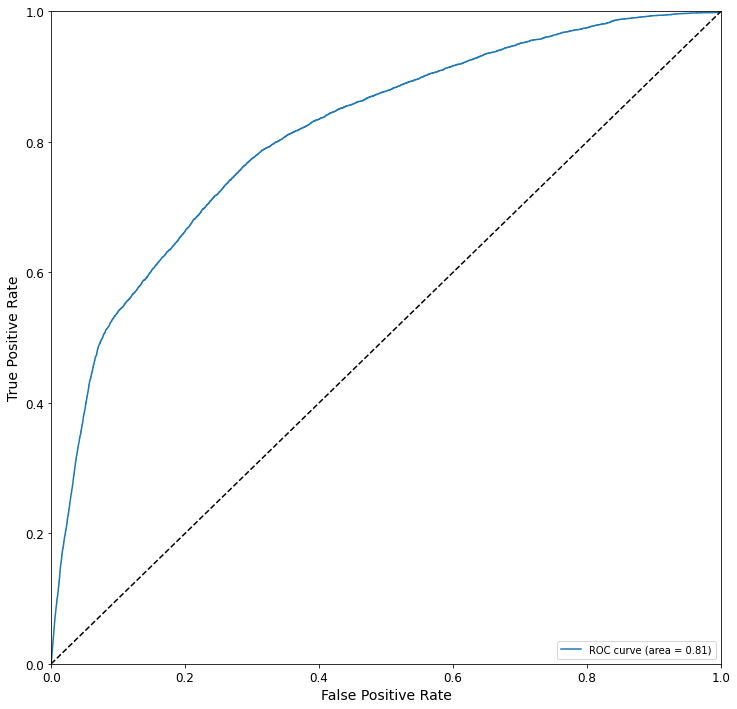

In [21]:
plt.figure(figsize = (12,12))
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
fpr, tpr, _ = metrics.roc_curve(y_test_class, class_models['naive_bayes']['probs'])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % class_models['naive_bayes']['ROC_AUC_test'])
plt.plot([0, 1], [0, 1], 'k--')  # coin toss line
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

##### *Figure 5: ROC Curve for Naïve Bayes.*

- **F1**: The _F1-score_ is also called the harmonic average of precision and recall because it's calculated like this: $2 \cdot TP$ / $2 \cdot TP + FP + FN$. Since it includes both precision and recall metrics, which pertain to the proportion of true positives, it's a good metric choice to use when your dataset is imbalanced.
- **MCC**: _Matthews Correlation Coefficient_ is a metric drawn from Biostatistics. It's gaining popularity in the broader data science community because it's the ability to produce high scores considering TP, FN, TN, and FP fairly because it takes into account proportions of classes. This makes it optimal for imbalanced classification tasks. Unlike all other metrics used so far, it doesn't range from $0$ to $1$ but $-1$, complete disagreement, to $1$, a total agreement between predictions and actuals. The mid-point, $0$, is equivalent to a random prediction.

Our classification metrics are mostly very good, exceeding a 96% accuracy and 75% recall. However, even recall isn't everything. For instance, RandomForest, due to its class balancing with weights, got the highest recall but did poorly in F1 and MCC, which suggests that precision is not very good. Ridge Classification also had the same setting and had such a poor F1 score; precision must have been dismal. This doesn't mean this weighting technique is inherently wrong, but often require more control. And this book will cover techniques to achieve the right balance between fairness and accuracy, accuracy and reliability, reliability and validity, etc. This is a balancing act that requires many metrics and visualizations. A key take away from this exercise should be that a **single metric will not tell you the whole story**, and interpretation is about telling the most relevant and sufficiently complete story.

Now, to complete this story we are going to try a few dimensionality reduction methods.

### Visualizing Delayed Flights with Dimensionality Reduction Methods

Visualization, and interpretation for that matter, do not always deal with tangibles. With machine learning, we are often dealing with latent relationships between features, that given their complexity, are hard to find and even harder to describe or visualize. And one effective way of reducing this complexity to visualize them is through dimensionality reduction methods, which help extract representations that, although lack a discernable name, might have some identifiable insights we can derive meaning from.

To compare and contrast dimensionality reduction methods, we will first create a dictionary for them named `dimred_methods`. Each method is it's own dictionary and the function that creates it in the `method` attribute. This structure will be used later to store the data once reduced neatly or in `cvae`'s case, the fitted model. Methods in this dictionary have been chosen to represent several families of methods to illustrate the important concepts that we will discuss later. Given the potentially resource-intensive nature of some of these methods, we are using an abbreviated 9-column version of our dataset for both train (`X_train_abbrev`), and test (`X_test_abbrev`). And we are also sampling only 10% of the test dataset using a randomly generated index (`sample_idx`). This is just a `numpy` array of numbers that tell us which observations were randomly selected. If you have more resources to work with, feel free to change the `sample_size` to a more significant percentage.

In [22]:
X_train_abbrev = X_train.ix[:,[0, 1, 2, 4, 8, 9, 11, 17, 20]]
X_test_abbrev = X_test.ix[:,[0, 1, 2, 4, 8, 9, 11, 17, 20]]
np.random.seed(rand)
sample_size = 0.1
sample_idx = np.random.choice(X_test.shape[0],\
                              math.ceil(X_test.shape[0]*sample_size), replace=False)

dimred_methods = {
        #Decomposition
        'pca':{'method': decomposition.PCA(n_components=3)},  
        #Manifold Learning
        't-sne':{'method': manifold.TSNE(n_components=3)},
        #Variational Autoencoders
        'vae':{'method': cvae.CompressionVAE(X_train_abbrev.values,\
                                             dim_latent=3, tb_logging=False)}, 
    }

Total amount of data:  688137
Input feature dimension:  9
Calculating normalisation factors.
Normalisation factors calculated.
Total amount of data:  76460
Creating model.
Model created.
Setting up loss.
Loss set up.
Setting up session.
Session set up.
Trying to restore saved checkpoints from /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter3/temp ... No checkpoint found.
No model found to restore. Initialising new model.


Before we begin to apply these methods to our data, we will briefly explain them one by one:

- **`pca`**: _Principal Component Analysis_ is one of the oldest techniques of dimensionality reduction, and it's usually done by performing eigenvalue decomposition of the covariance matrix of the data. Unlike the others we are exploring here, it's computationally speedy. The process of eigenvalue decomposition finds orthogonal vectors, which means that geometrically far apart. This is so PCA can reduce dimensions to ones that are uncorrelated to each other. It is called principal components because eigenvectors are also called _principal directions_. This makes sense because data is reduced by projecting data to fewer dimensions while trying not to lose information.
- **`t-sne`**: _T-distributed Stochastic Neighbor Embedding_ is one of the newer methods of dimensionality reduction, and unlike PCA, it is non-linear, so it's good at capturing non-linearities. An, unlike PCA, the mathematical theory behind t-SNE is not linear algebra, but probability. It minimizes the difference between pairwise distribution similarities between high-dimensional (our input data) and the lower-dimensional representation using Kullback-Leibler divergence (which is a distance measurement). Unlike PCA that focusses on putting dissimilar points as far apart as possible, t-SNE is about placing similar points close together. 
- **`vae`**: _Variational Autoencoders_ is a deep learning method that learns how to best encode data from high dimension and then decode it back from low to high dimension. Since it uses linear algebra for the neural network and measures Kullback-Leibler divergence between probability distributions, it has elements from both PCA and t-SNE. Of course, it's different in many ways. While VAE's minimize the reconstruction error between original and reconstructed data, it doesn't preserve distances between similar points on a granular level like t-SNE does. Unlike both PCA and t-SNE, VAE provides reversibility between low dimension and higher dimensions and can even generate new data.

Please note that for all of the methods, we are reducing data to three _components_ (`n_components=3`) or _dimensions_ (`dim_latent=3`). Also, `vae` is not just a dimensionality reduction method but a machine learning model class, so it will train on data first, so unlike the others, we will use the abbreviated training data `X_train_abbrev` to this effect.

Now, let's iterate over our dictionary of methods (`dimred_methods`), perform the dimensionality reduction with each method. In `vae`'s case, there will be a fitted model too. Lastly, we save the reduced data and fitted model for `vae`, in the dictionary for later use. Two of these methods take a few minutes each, so don't worry if it takes a while.

In [23]:
for method_name in dimred_methods.keys():
    if method_name != 'vae':
        lowdim_data = dimred_methods[method_name]['method'].\
                        fit_transform(X_test_abbrev.values[sample_idx])
    else:
        fitted_model = dimred_methods[method_name]['method'].train(num_steps=1000)
        lowdim_data = fitted_model.embed(X_test_abbrev.values[sample_idx])
        dimred_methods[method_name]['fitted'] = fitted_model
    dimred_methods[method_name]['lowdim'] = lowdim_data

Starting queues.
Reader threads started.
step 0; epoch 0.00 - loss = 7.180, test_loss = 12.238, lr = 0.00100, (0.208 sec/step)
Storing checkpoint to /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter3/temp ... Done.
step 50; epoch 0.00 - loss = 6.045, test_loss = 10.590, lr = 0.00100, (0.156 sec/step)
step 100; epoch 0.01 - loss = 4.870, test_loss = 9.740, lr = 0.00100, (0.159 sec/step)
step 150; epoch 0.01 - loss = 4.292, test_loss = 9.706, lr = 0.00100, (0.149 sec/step)
step 200; epoch 0.02 - loss = 4.373, test_loss = 9.575, lr = 0.00100, (0.149 sec/step)
step 250; epoch 0.02 - loss = 4.888, test_loss = 9.450, lr = 0.00100, (0.146 sec/step)
step 300; epoch 0.03 - loss = 4.005, test_loss = 9.385, lr = 0.00100, (0.145 sec/step)
step 350; epoch 0.03 - loss = 4.666, test_loss = 9.341, lr = 0.00100, (0.141 sec/step)
step 400; epoch 0.04 - loss = 4.896, test_loss = 9.301, lr = 0.00100, (0.142 sec/step)
step 450; epoch 0.04 - loss = 5.123, test_loss = 9.347, lr = 0.00100, (

So what can we do with the low dimensional data we now have? For starters, we can visualize it! So one neat visualization we can do is plot the three dimensions - let's call them x, y and z - as two dimensions at a time, while we show in different colors our classifications. This will be like seeing them 3-dimensions from different angles (front, side and top). To do this, we will create a plotting function `plot_3dim_decomposition` which takes our low dimensional data $Z$ and plots it's three dimensions while color-coding the `y_labels`. Initially, our labels can be our actual $y$'s (coding 0 for not delayed and 1 for delayed), but so that it can display a legend, we will also include `y_names`, which is a dictionary that helps translate these in the plot legend.

In [24]:
y_names = {0:'Not Delayed', 1:'Delayed'}
def plot_3dim_decomposition(Z, y_labels, y_names):
    if len(y_names) > 2:
        cmap = 'plasma_r'
    else:
        cmap = 'viridis'
    fig, axs = plt.subplots(1, 3, figsize = (16,4))
    fig.subplots_adjust(hspace=0, wspace=0.3)
    scatter = axs[0].scatter(Z[:,0], Z[:,1],\
                             c=y_labels, alpha=0.5, cmap=cmap)
    legend = axs[0].legend(*scatter.legend_elements(), loc='best')
    for n in y_names.keys(): 
        legend.get_texts()[n].set_text(y_names[n])
    axs[0].set_xlabel('x', fontsize = 12)
    axs[0].set_ylabel('y', fontsize = 12)
    scatter = axs[1].scatter(Z[:,1], Z[:,2],\
                   c=y_labels, alpha=0.5, cmap=cmap)
    legend = axs[1].legend(*scatter.legend_elements(), loc='best')
    for n in y_names.keys(): 
        legend.get_texts()[n].set_text(y_names[n])
    axs[1].set_xlabel('y', fontsize = 12)
    axs[1].set_ylabel('z', fontsize = 12)
    axs[2].scatter(Z[:,0], Z[:,2],\
                   c=y_labels, alpha=0.5, cmap=cmap)
    legend = axs[2].legend(*scatter.legend_elements(), loc='best')
    for n in y_names.keys(): 
        legend.get_texts()[n].set_text(y_names[n])
    axs[2].set_xlabel('x', fontsize = 12)
    axs[2].set_ylabel('z', fontsize = 12)
    plt.show()

Now let's plot PCA's low-dimensional data against the sampled `y_test_class`:

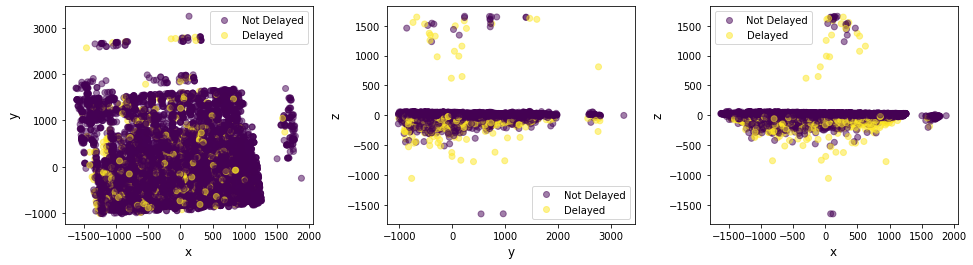

In [25]:
plot_3dim_decomposition(dimred_methods['pca']['lowdim'],\
                        y_test_class.values[sample_idx], y_names)

##### *Figure 6: PCA with 3 components plotted in 2 dimensions at a time and color-coded for labels.*

You can tell "delayed" is separable, in some parts, from not delayed, and this is clearer when comparing some dimensions than others. How about we do the same for t-SNE and VAE?

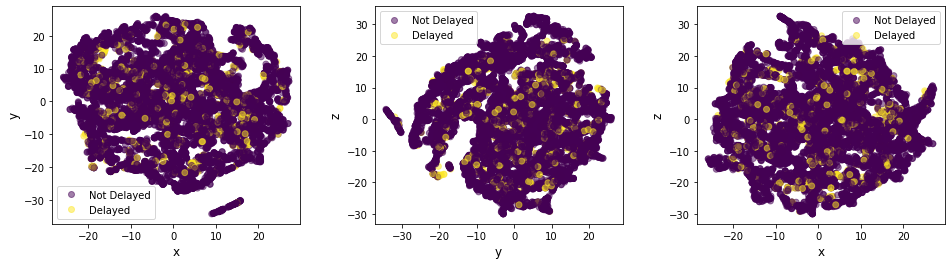

In [26]:
plot_3dim_decomposition(dimred_methods['t-sne']['lowdim'],\
                        y_test_class.values[sample_idx], y_names)

##### *Figure 7: t-SNE with 3 component plotted in 2 dimensions at a time and color-coded for labels.*

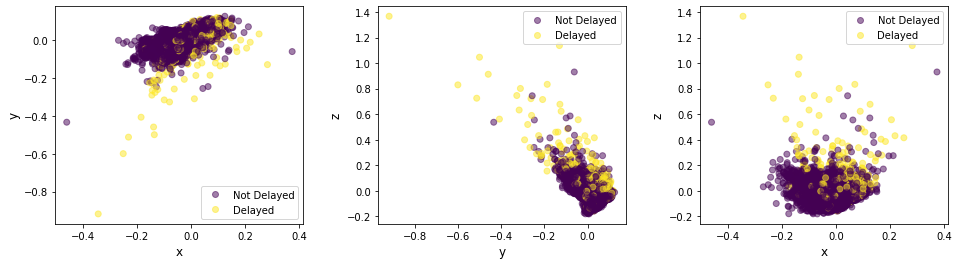

In [27]:
plot_3dim_decomposition(dimred_methods['vae']['lowdim'],\
                        y_test_class.values[sample_idx], y_names)

##### *Figure 8: VAE with 3 dimensions plotted in 2 dimensions at a time and color-coded for labels.*

t-SNE is very dense, but you still find clusters in which delays are prevalent, and with VAE, it's harder to identify the clusters, especially in the area where most of the purple is concentrated. As you can tell by these initial steps, these techniques can be used to identify areas where your classes are most concentrated in... But is all there's to it? There are many ways in which dimensionality reduction can be leveraged. Some are entirely visual, and others can be extended to enhance feature selection and engineering, anomaly detection, and even the modeling where you can use it to make sense of intermediate steps. We will examine some of these ways later in the book. But sticking to the visualizations, for now, you can even use it to debug models. For instance, if instead of the actual binary classes you displayed the classification errors ($FP$, $FN$), or lack thereof ($TP$, $TN$), for each of your observations, you could visualize where most of your errors for a particular model is located. To that end, we will need to create a function that takes our actuals and model predictions and returns the array of classification errors (`error_vector`). Also, it's a corresponding dictionary for the plot legend `error_labels`. We can then plug this into the very same `plot_3dim_decomposition` function.

In [28]:
def encode_classification_error_vector(y_true, y_pred):
    error_vector = (y_true * 2) - y_pred
    error_vector = np.where(error_vector==0, 4, error_vector + 1)
    error_vector = np.where(error_vector==3, 0, error_vector - 1)
    error_vector = np.where(error_vector==3, error_vector, error_vector + 1)
    error_labels = {0:'FP', 1:'FN', 2:'TP', 3:'TN'}
    return error_vector, error_labels

Now that we have the function, we can use it to extract the classification errors for the Ridge classifier we fitted earlier, and it's a dictionary. We are using Ridge because it was one of our worse-performing classifiers.

In [29]:
y_test_class_samp = y_test_class.values[sample_idx]
y_test_pred_samp = class_models['ridge']['preds'][sample_idx]
error_vector, error_labels = encode_classification_error_vector(y_test_class_samp,\
                                                                y_test_pred_samp)

Now we can visualize these classification errors using all 3 dimensionality reduction methods:

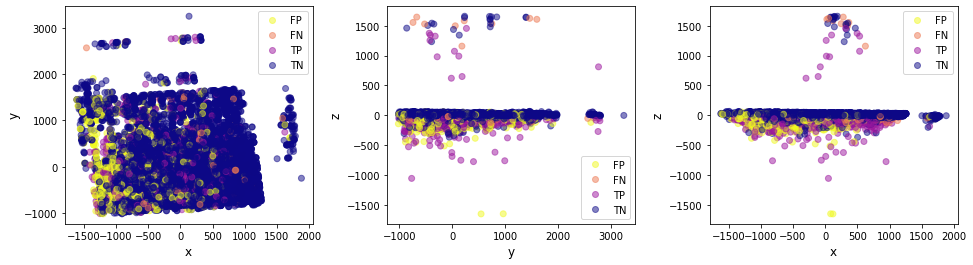

In [30]:
plot_3dim_decomposition(dimred_methods['pca']['lowdim'],\
                        error_vector, error_labels)

##### *Figure 9: PCA with 3 components plotted in 2 dimensions at a time and color-coded for classifcation errors.*

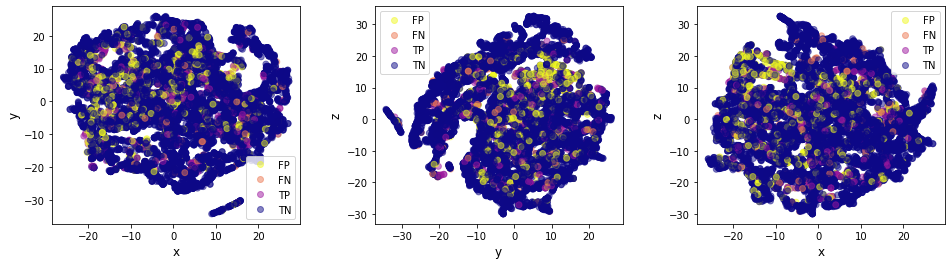

In [31]:
plot_3dim_decomposition(dimred_methods['t-sne']['lowdim'],\
                        error_vector, error_labels)

##### *Figure 10: t-SNE with 3 components plotted in 2 dimensions at a time and color-coded for classifcation errors.*

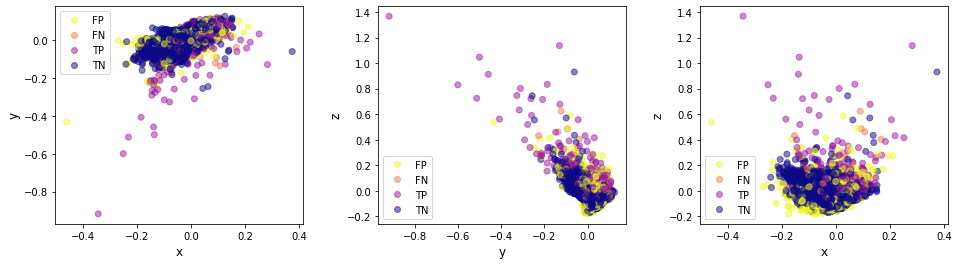

In [32]:
plot_3dim_decomposition(dimred_methods['vae']['lowdim'],\
                        error_vector, error_labels)

##### *Figure 11: VAE with 3 dimensions plotted in 2 dimensions at a time and color-coded for classifcation errors.*

In all three, you can identify "weak" areas where yellow (FP) and orange (FN) are prevalent. You can dig deeper into these areas and try different combinations of features on dimensionality reduction to see if it makes a difference. Or even perform some transformations to your features. If you find three dimensions lack the _expressiveness_ to represent, patterns try more dimensions. There's a lot to explore here.

If dimensionality reduction techniques capture the essence of your datasets, why not train on that? In some cases, it makes sense to do so, but x, y, and z lack inherent meaning, and **meaning is indispensable for interpretation**. But you can find meaning in clusters where your models are misclassifying, and this could be extended to all your models. In fact, you could ask and answer the question, where do all my models have false positives or negatives? You could find clusters where this happens and incorporate these insights into your models. 

Using visualization to examine models, decisions aren't limited to dimensionality reduction methods. Some model classes are easy to visualize, as we later cover in this chapter.

Now, let's examine some limitations of the traditional methods we've been practicing.

## Limitations of Traditional Model Interpretation Methods

In a nutshell, traditional interpretation methods **only cover surface-level questions about your models** such as, on a global level, do they perform well? And _what_ changes in hyperparameters may impact predictive performance? And _what_ latent patterns can you find between the features and their predictive performance?

These questions are very limiting if you are trying to understand not only if you model works but _why_? And _how_? This gap in understanding can lead to unexpected issues with your model that won't necessarily be immediately apparent. Let's consider that models, once deployed, are not static but dynamic. They face different challenges than it did in the "lab" when you were training them. They may face not only performance issues but issues with bias such as imbalance with underrepresented classes or security with adversarial attacks. Realizing that the features have changed in the real-world environment, we might have to add new features instead of merely retraining with the same feature-set. Realizing that there are some troubling assumptions made by your model, you might have to re-examine the whole pipeline. But how do you recognize these problems exist in the first place? That's when you will need a whole new set of interpretation tools that can help you dig deeper and answer more specific questions about your model. These tools provide interpretations that can truly account for F.A.T (Fairness, Accountability and Transparency) we discussed in Chapter 1 (_Interpretation, Interpretability, and Explainability; and why does it all matter?_)

## Intrinsically interpretable models (White-box)

So far, in this chapter, we have already fitted our training data to model classes representing each of these model families. The purpose of this section is to show you exactly why they are _inherently interpretable_ (also known as _white-box_ models). We do so using the models that were previously fitted.

### Generalized Linear Models (GLMs)

GLM is a large family of model classes that have a model for every statistical distribution. Just like _Linear Regression_ assumes your target feature and residuals has a normal distribution, _Logistic Regression_ assumes the Bernoulli distribution. There are GLMs for every distribution, such as _Poisson Regression_ for Poisson distribution and _Multinomial Response_ for multinomial distribution. You choose which GLM to use based on the distribution of your target variable and if your data meets the other assumptions of the GLM (they vary). In addition to an underlying distribution, what ties GLMs together into a single-family is the fact that they all have a linear predictor. In other words, the $\hat{y}$ target variable (or predictor) can be expressed mathematically as a weighted sum of $X$ features, where weights are called $\beta$ coefficients. This is the simple formula, the linear predictor function, that all GLMs share:   

$\hat{y} = \beta X$

However, although they share this same formula, they each have a different link function, which provides a link between the linear predictor function and the mean of the statistical distribution of the GLM. This can add some non-linearity to the resulting model formula while retaining the linear combination between the $\beta$ coefficients and the $X$ input data, which can be a source of confusion. Still, it's linear because of the linear combination.

There are also many variations for specific GLMs. For instance, _Polynomial Regression_ is _Linear Regression_ with polynomials of its features, and _Ridge Regression_ is Linear Regression with L2 regularization. We won't cover all GLMs in this section because they weren't needed for the example in this chapter, but all have plausible use cases. Incidentally, there's also a similar concept called _Generalized Additive Models_ (GAMs) that are GLMs that don't require linear combinations of features and coefficients and instead retain the addition part, but of arbitrary functions applied on the features. GAMs are also interpretable, but they are not as common, and usually tailored to specific use cases _ad-hoc_.

#### Linear Regression

In Chapter 1 (_Interpretation, Interpretability, and Explainability, and why does it all matter?_), we covered the formula of simple linear regression, which only has a single $X$ feature. Multiple linear regression extends this to have any amount of features so instead of being:

$\hat{y} = \beta_0 + \beta_1 X_1$

it can be:

$\hat{y} = \beta_0 + \beta_1 X_1 + \beta_2 X_2 \text{...}  + \beta_n X_n$ with $n$ features, and where $\beta_0$ is the intercept

and thanks to linear algebra this can be a simple matrix multiplication:

$\hat{y} = \beta X$

The method used to arrive at the optimal $\beta$ coefficients, Ordinary Least Squares (OLS), is a well studied and understood. Also, in addition to the coefficients, you can extract confidence intervals for each. The model's correctness depends on whether the input data meets the assumptions: linearity, normality, independence, (mostly) lack of multicollinearity, and homoscedasticity. We discussed linearity, so far, quite a bit so we will briefly explain the rest:

- **Normality** is that each feature is normally distributed. This can be tested with a Q-Q plot, histogram or Kolmogorov-Smirnov test, and non-normality can be corrected with non-linear transformations. If a feature isn't normally distributed, it will make its coefficients confidence intervals invalid.
- **Independence** is that each _observation_ (the rows in your dataset) is independent of each other, like different and unrelated events. If your _observations_ isn't independent, it could affect your interpretation of results. In this chapters' example, if you had multiple rows about the same flight that could violate this assumption and makes results hard to understand. This can be tested by looking for duplicates.
- **Lack of multicollinearity** is desirable because otherwise, you'll have inaccurate coefficients. Multicollinearity occurs when the features are highly correlated with each other. This can be tested with a correlation matrix, tolerance measure, or Variance Inflation Factor (VIF), and it can be fixed by removing one of each highly correlated feature.
- **Homoscedasticity** we briefly discussed in Chapter 1, and it's that the residuals (the error) are more or less equal across the regression line. This can be tested with the Goldfeld-Quandt Test, and heteroscedastic (the lack of homoscedasticity) can be corrected with non-linear transformations. This assumption is often violated in practice.

Even though we haven't done it for this chapters' example, if you are going to rely on linear regression heavily, it's always good to test these assumptions before you even begin to fit your data to a linear regression model. This book won't detail how this is done because it's more about model-agnostic and deep-learning interpretation methods than delving into how to meet the assumptions of a specific class of models normality and homoscedasticity. However, we covered the characteristics that trump interpretation the most in Chapter 2 (_Interpretation Challenges_), and we will continue to look for these characteristics: **non-linearity**, **non-monotonicity** and **interactivity**. We will do this, mainly, because the linearity and correlation of and between features are still relevant, regardless of the modeling class used to make predictions. And these are characteristics that can be easily tested for in methods used for linear regression. 

##### Interpretation

So how do we interpret a linear regression model? Easy! Just get the coefficients and the intercept. Our _scikit learn_ models have these attributes embedded in the fitted model:

In [33]:
coefs_lm = reg_models['linear']['fitted'].coef_
intercept_lm = reg_models['linear']['fitted'].intercept_
print('coefficients:\t%s' % coefs_lm)
print('intercept:\t%s' % intercept_lm)

coefficients:	[ 4.54984539e-03 -5.25067742e-03  8.94125541e-01 -1.52961053e-02
 -4.69623002e-01  1.25277815e-01 -6.46744472e-04 -1.26240049e-02
  4.50112895e+01  6.76385421e-04 -3.69920254e-04  5.47855860e-04
  3.73866548e-01 -9.06364154e-01 -6.74052666e-01 -9.17411191e-01
 -9.29843952e-01 -3.96621856e-02 -1.79666480e-02 -1.02912927e+00
 -3.94934854e-01]
intercept:	-37.861779327526676


So now you know the formula looks something like this:

In [34]:
print('ŷ = %0.2f + %0.3fX₁ + %0.3fX₂ + %0.3fX₃ + ...' %\
      (intercept_lm, coefs_lm[0], coefs_lm[1], coefs_lm[2]))

ŷ = -37.86 + 0.005X₁ + -0.005X₂ + 0.894X₃ + ...


This formula should provide some intuition on how the model can be interpreted globally. Interpreting each coefficient in the model can be done for multiple linear regression, just as we did with the simple linear regression example in Chapter 1. The coefficients act as weights, but they also tell a story that varies depending on the kind of feature. To make interpretation more manageable, let's put our coefficients in dataframe alongside the names of each feature:

In [ ]:
coef_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'coef': coefs_lm})
coef_df

![png](./Chapter3_files_extra/Fig_12.png)
##### *Figure 12: Coefficients of Linear Regression features.*

To interpret a feature, if it is...

- **Continuous**: like `ARR_RFPH` you know that for every one unit increase (relative flights per hour), it increases the predicted delay by $0.373844$ minutes, it's coefficient if all other features stay the same.
- **Binary**: like `ORIGIN_HUB`, you know that difference between the origin airport being a hub or not, is expressed by the coefficient $-1.029088$. In other words, since it's a negative number, the origin airport is a hub. It reduces the delay by just over one minute if all other features stay the same.
- **Categorical**: We don't have categorical features, but we have ordinal features that could have been, and ***actually should have been***, categorical features. For instance, `DEP_MONTH` and `DEP_DOW` are integers from 1-12 and 0-6, respectively. If they are treated as ordinals, we are assuming because of the linear nature of linear regression that an increase or decrease in months has an impact on the outcome. Same with the day of the week. But the impact is tiny. Had we treated them as dummy or one-hot encoded variables, we could measure if Fridays are more hectic than Saturdays and Wednesdays, or Julys than Octobers and Junes. This couldn't possibly be modeled with them in order, because they have no relation to this order (Yep! It's non-linear). So, say, we had a feature called `DEP_FRIDAY` and another called `DEP_JULY`, they are treated like binary features and can tell you what effect precisely does a departure being on a Friday or in July have on the model. Some features were kept as ordinal or continuous on purpose despite being good candidates for categorical to demonstrate how not making the right adjustments to your features can impact the _expressive power_ of model interpretation. It would have been good to tell airline executives more about how the day and time of a departure impacted delays. Also, in some cases - not in this one - an oversight like this can grossly affect model performance. 

The intercept ($-37.86$) is not a feature, but it does have a meaning, which is if all features were at $0$, what would the prediction be. In practice, this doesn't happen unless your features happen to all have a plausible reason to be $0$. Just as in Chapter 1, you wouldn't have expected anyone to have a height of $0$. In this example, you wouldn't expect a flight to have a distance of $0$. However, if you standardized the features so that they had a mean of $0$, then you would change the interpretation of the intercept to be the prediction you expect if all features are their mean value.

##### Feature Importance

The coefficients can also be leveraged to calculate feature importance. Unfortunately, sci-kit learns' linear regressor is ill-equipped to do this because it doesn't output the standard error of the $\beta$ coefficients. According to their importance, all it takes to rank features is to divide the $\beta$s by their corresponding standard errors. This result is something called the t-statistic:

$t_{\beta_i} = \frac{\beta_i}{SE(\beta_i)}$

And then you take an absolute value of this and sort them from high to low. It's easy enough to calculate, but you need the standard error. You could reverse engineer the linear algebra involved to retrieve it using the intercept, and the coefficients returned by sci-kit learn. However, it's probably a lot easier than you fit the linear regression model again, but this time using the `statsmodels` library, which has a summary with all the statistics, including $t$! By the way, `statsmodels` names their linear regressor `OLS` which makes sense because Ordinary Least Squares is the name of the mathematical method that fits the data. 

In [ ]:
linreg_mdl = sm.OLS(y_train_reg.values, sm.add_constant(X_train.values))
linreg_mdl = linreg_mdl.fit()
linreg_mdl.summary()

![png](./Chapter3_files_extra/Fig_13.png)
##### *Figure 13: The statsmodels Linear Regression summary.*

Unfortunately, as you can tell by the summary, `statsmodels` don't keep the features' names, so this makes interpretation harder. In any case, there's quite a bit to unpack in this summary. This book won't address everything here except that the t-statistic can tell you how important features are in relation to each other. There's another more pertinent statistical interpretation, which is if you were to hypothesize that the $\beta$ coefficient is 0, in other words, that the feature has no impact on the model, the distance of t-statistic from 0 helps reject that null hypothesis. This is what the _p-value_ to the right of the t-statistic does. It's no coincidence that the closest $t$ to 0 (for `x14`) has the only p-value above 0.05. This puts this feature at a level of insignificance since everything below 0.05 is statistically significant according to this method of hypothesis testing.

So to rank our features, let's extract the data frame from the `statsmodels` summary. Then, we drop the `const` (the intercept) because this is not a feature. We need the names of the features to make sense of it, so we turn this array of features into its dataframe. Then, we `concat` the names dataframe with the summary dataframe. Finally, we make a new column with the absolute value of the t-statistic and sort it accordingly. To demonstrate how the absolute value of the t-statistic and p-value are inversely related, we are also color-coding these columns:

In [ ]:
summary_df = linreg_mdl.summary2().tables[1]
summary_df = summary_df.drop(['const']).reset_index(drop=True) 
names_df = pd.DataFrame({'feature':X_train.columns.values})
summary_df = pd.concat([names_df, summary_df], axis=1)
summary_df['t_abs'] = abs(summary_df['t'])
summary_df.sort_values(by='t_abs', ascending=False).style.\
    background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['P>|t|']).\
    background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['t_abs'])

![png](./Chapter3_files_extra/Fig_14.png)
##### *Figure 14: Linear Regression summary table sorted by the absolute value of the t-statistic.*

Something particularly interesting about this feature importance is that different kinds of delays occupy 5 out of the top 6 positions. Of course, this could be because linear regression is confounding different non-linear effects these have, or perhaps there's something here we should look more in to. Especially since `statsmodels` summary under the "Warnings" section cautions: 

> "[2] The condition number is large, 5.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.".

This is odd. Hold that thought. We will examine this further later.

#### Ridge Regression

Ridge regression is part of a sub-family of _penalized_ or _regularized_ regression along with the likes of LASSO and ElasticNet because, as explained earlier in this chapter, it penalizes using the _L2 norm_. This sub-family is also called _sparse linear models_ because, thanks to the regularization, it cuts out some of the noise by making irrelevant features less relevant. Sparsity in this context means less is more because reduced complexity will lead to lower variance and improved generalization. To illustrate this concept, look at the feature importance table, we outputted for linear regression. Something that should be immediately apparent is how the `t_abs` column starts with every row a different color, and then a whole bunch of them are the same shade of yellow. Because of the variation in confidence intervals, the absolute t-value is not something you can take proportionally and say that your top feature is hundreds of times more relevant than every one of your bottom ten features. However, it should indicate that there are significantly more important features than others to the point of irrelevance, and possibly confoundment, hence creating noise. There's ample research on how there's a tendency for a small subset of features to have the most substantial effects on the outcome of the model. This is called the _bet on sparsity principle_ [[^2]]. Whether it's true or not for your data, it's always good to test the theory by applying regularization, especially in cases where data is very wide (many features) or exhibits multicollinearity. These regularized regression techniques can be incorporated in to feature selection processes or to inform your understanding of what features are essential. 

There is a technique to adapt ridge regression to classification problems. It was briefly discussed before. It converts the labels to a $-1$ to $1$ scale for training to predict values between $-1$ and $1$, and then turn them back to $0-1$ scale. However, it uses regularized linear regression to fit the data. And can be interpreted in the same way.

##### Interpretation

Ridge regression can be interpreted in the same way as linear regression, both globally and locally, because once the model has been fitted, there's no difference. The formula is the same:

$\hat{y} = \beta^{ridge} X$

Except $\beta^{ridge}$ coefficients are different because they were penalized with a $\lambda$ parameter, which controls how much _shrinkage_ to apply.

We can quickly compare coefficients by extracting the ridge coefficients from their fitted model and placing them side by side in a dataframe with the coefficients of the linear regression. As you can tell, the color-coding, they are always slightly different, but sometimes they are lower and sometimes higher.

In [ ]:
coefs_ridge = reg_models['ridge']['fitted'].coef_
coef_ridge_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'coef_linear': coefs_lm,\
                        'coef_ridge': coefs_ridge})
coef_ridge_df.style.\
    background_gradient(cmap='viridis_r', low=0.3, high=0.2, axis=1)

![png](./Chapter3_files_extra/Fig_15.png)
##### *Figure 15: Linear Regression coefficients compared to Ridge Regression coefficients.*

We didn't save the $\lambda$ parameter (which sci-kit learn calls _alpha_) that the ridge regression cross-validation deemed optimal. However, we can run a little experiment of our own to figure out which parameter was the best. We do this by iterating through 100 possible alphas values between $10^{0}$ ($1$) and $10^{13}$ ($10000000000000$), fitting the data to Ridge model which each alpha and then appending the coefficients to an array. We exclude the last coefficient in the array because it's so much larger than the rest.

In [39]:
num_alphas = 100
alphas = np.logspace(0, 13, num_alphas)
alphas_coefs = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha).fit(X_train, y_train_reg)
    alphas_coefs.append(ridge.coef_[:20])

Now that we have an array of coefficients, we can plot the progression of coefficients:

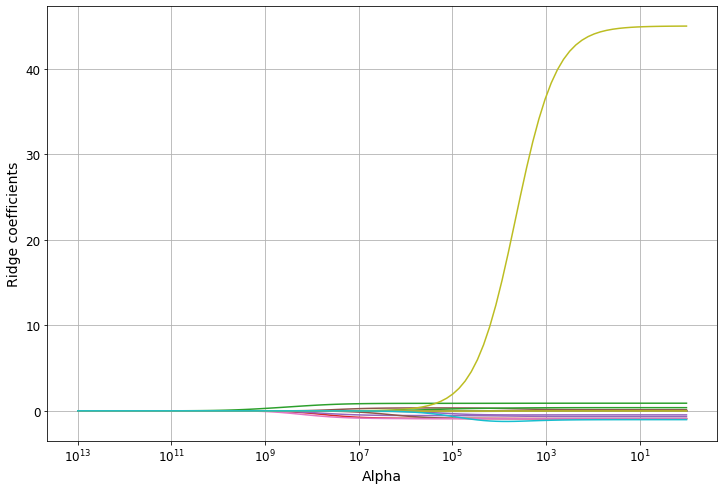

In [40]:
plt.figure(figsize = (12,8))
plt.gca().invert_xaxis()
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.plot(alphas, alphas_coefs)
plt.xscale("log")
plt.xlabel('Alpha', fontsize = 14)
plt.ylabel('Ridge coefficients', fontsize = 14)
plt.grid()
plt.show()

##### *Figure 16: Value of alpha hyperparameter versus value of Ridge Regression coefficients.*

#### //Interpretation and Hyperparameters//

##### //Something to note is that the higher the alpha, the higher the regularization. This is why when alpha is $10^{12}$, all coefficients have converged to $0$, and as the alpha becomes smaller, they get to a point where they have all have diverged and more or less stabilized. In this case, this point is reached at about $10^{2}$. Another way of seeing it is when all coefficients are around $0$, it means that the regularization is so strong that all features are irrelevant. When they have sufficiently diverged and stabilized, the regularization makes them all relevant, which defeats the purpose. Now on that note, if we go back to our code will find that this is what we chose for alphas in our `RidgeCV`: `alphas=[1e-3, 1e-2, 1e-1, 1]`. As you can tell by the above plot by the time the alphas have reached $1$ and below, the coefficients have already stabilized. However, they are still fluctuating slightly. This can explain why our ridge was not better performing than linear regression. Usually, you would expect a regularized model to perform better than one that isn't - unless your hyperparameters are not right. The alphas chosen for RidgeCV were selected on purpose to be able to convey this point: ***Regularization can only work if you chose hyperparameters correctly***.//

##### Feature Importance

Precisely the same as with linear regression, but again we need standard error of the coefficients, which is something that cannot be extracted from the sci-kit learn model. You can use `statsmodels` `fit_regularized` method to this effect.

[^2]: Hastie, T., R. Tibshirani, and M. Wainwright. 2015. Statistical Learning with Sparsity: The Lasso and Generalizations. Chapman & Hall/Crc Monographs on Statistics & Applied Probability. Taylor & Francis.

#### Polynomial Regression

Polynomial regression is a special case of linear or logistic regression where the features have been expanded to have higher degree terms. We only have performed polynomial linear regression in this chapter exercise, so we will only discuss this variation. However, it is applied similarly. 

A two feature multiple linear regression would look like this:

$\hat{y} = \beta_0 + \beta_1 X_1 + \beta_2 X_2$

but in polynomial regression, every feature is expanded to have higher degree terms and interactions between all the features. So, if this 2 feature example were to be expanded to a second degree polynomial, the linear regression formula would look like this:

$\hat{y} = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1^2 + \beta_4 X_1 X_2 + \beta_5 X_2^2$

It's still linear regression in every way except it has extra features, higher degree terms, and interactions. While you can limit polynomial expansion to only one or a few features, we used `PolynomialFeatures` that does this to all features. Therefore 21 features were likely multiplied many times over. We can extract the coefficients from our fitted model and using the `shape` property of the `numpy` array return how many coefficients were generated. This amount corresponds to the number of features generated:

In [41]:
print(reg_models['linear_poly']['fitted'].get_params()['linearregression'].coef_.shape[0])

253


We can do the same with the version of polynomial regression, which was interaction terms only. The reality is that most terms in a polynomial generated like this are interactions between all the features.

In [42]:
print(reg_models['linear_interact']['fitted'].get_params()['linearregression'].coef_.shape[0])

232


##### Interpretation and Feature Importance

Polynomial regression can be interpreted, both globally and locally, in precisely the same way as linear regression. In this case, it's not practical to understand a formula with 254 linearly combined terms, so it looses what we defined in Chapter 2 (_Key Concepts of Interpretability_) as _Global Holistic Interpretation_. However, it still can be interpreted in all other scopes and retains many of the properties of linear regression. For instance, since the model is additive, so it easy to separate the effects of the features. You can also use the same many peer-reviewed tried and tested statistical methods used for linear regression. For instance, you can use the t-statistic, p-value, confidence bounds, R-square, as well as the many tests used to assess goodness or lack of fit, residual analysis, linear correlation, and analysis of variance. This wealth of statistically proven methods to test and interpret models isn't something most model classes can count on. Unfortunately, many of them are model-specific to linear regression, and it's special cases.

Also, we won't do it here because they are so many terms. Still, you could undoubtedly rank features for polynomial regression in the same way we have for linear regression using the `statsmodels` library. The challenge is figuring out the order of the features generated by `PolynomialFeatures` to name them accordingly in the feature name column. Once this is done, you can tell if some second-degree terms or interactions are important. This could tell you if these features have a non-linear nature or highly depend on other features.

#### Logistic Regression

We discussed logistic regression as well as its interpretation and feature importance in Chapter 2 (_Key Concepts of Interpretability_). We will only expand on that a bit here in the context of this chapter's classification exercise and to underpin why exactly it is interpretable. The fitted logistic regression model has coefficients and intercepts just as the linear regression model does:

In [43]:
coefs_log = class_models['logistic']['fitted'].coef_
intercept_log = class_models['logistic']['fitted'].intercept_
print('coefficients:\t%s' % coefs_log)
print('intercept:\t%s' % intercept_log)

coefficients:	[[-1.27069362e-03  5.09665795e-04  1.59630833e-01  1.02944311e-03
  -2.11899891e-03 -4.58141272e-03  1.02391493e-04 -5.12112254e-02
  -1.73644925e-03  5.61755134e-03 -3.87345638e-04 -7.28677306e-03
  -2.69765469e-03 -1.49758286e-01 -1.18126066e-01 -5.84690112e-03
  -1.63318068e-01 -1.29021715e-02 -5.24114721e-03  4.64923898e-04
  -2.03265287e-03]]
intercept:	[-0.00226854]


However the way these coefficients appear in the formula for the a specific prediction $\hat{y}^{(i)}$ is entirely different:

$P(\hat{y}^{(i)}=1) = \frac{e^{\beta_0 + \beta_1 X_1^{(i)} + \beta_2 X_2^{(i)} \text{...}  + \beta_n X_n^{(i)}}}{1 + e^{\beta_0 + \beta_1 X_1^{(i)} + \beta_2 X_2^{(i)} \text{...}  + \beta_n X_n^{(i)}}}$

In other words, the probability that $\hat{y}^{(i)} = 1$ (is a positive case) is expressed by a logistic function that involves exponentials of the linear combination of $\beta$ coefficients and the $x$ features. The presence of the exponentials explains why the coefficients extracted from the model are log-odds because to isolate the coefficients, and you should apply a logarithm to both sides of the equation.

##### Interpretation

To interpret each coefficient you do it in precisely the same way with linear regression, except each unit increase in the features, you increase the odds of getting the positive case by a factor expressed by the exponential of the coefficient - if all things being equal (remember the ***ceteris paribus*** assumption discussed in Chapter 2). An exponential ($e^{\beta}$) has to be applied to each coefficient because they express an increase in log-odds and not odds. Besides incorporating the log-odds into the interpretation, the same said about continuous, binary, and categorical in linear regression interpretation apply to logistic regression.

##### Feature Importance

Frustrating as it is, there isn't consensus yet from the statistical community on how to best get feature importance for logistic regression. There's a standardize-all-features-first method, a pseudo-$R^2$ method [[^3]], a one-feature-at-a-time ROC AUC methods, a partial chi-squared statistic method and then the simplest one which is multiplying the standard deviations of each feature times the coefficients. We won't cover all these methods, but it has to be noted that computing feature importance consistently and reliably is a problem for most model classes, even white-box ones. We will dig deeper into this in Chapter 4 (_Fundamentals of Features Importance and Impact_). For logistic regression, perhaps the most popular method is achieved by standardizing all the features before training. That is, making sure they are centered at zero and divided by their standard deviation. But we didn't do this because although it has other benefits, it makes interpretation of coefficients more difficult, so we are using here the rather crude method leveraged in Chapter 2 which is to multiply the standard deviations of each feature times the coefficients:

In [44]:
stdv = np.std(X_train, 0)
abs(coefs_log.reshape(21,) * stdv).sort_values(ascending=False)

DEP_DELAY             7.065964
CRS_ELAPSED_TIME      4.064932
LATE_AIRCRAFT_DELAY   4.035862
DISTANCE              3.648190
NAS_DELAY             1.627782
WEATHER_DELAY         1.564935
CRS_DEP_TIME          0.637135
DEP_TIME              0.262430
ARR_AFPH              0.257684
CRS_ARR_TIME          0.204570
WHEELS_OFF            0.052895
TAXI_OUT              0.045215
DEP_MONTH             0.044031
DEP_AFPH              0.036499
DEP_DOW               0.010474
SECURITY_DELAY        0.009584
ARR_RFPH              0.001946
DEP_RFPH              0.001197
DEST_HUB              0.000989
ORIGIN_HUB            0.000226
PCT_ELAPSED_TIME      0.000183
dtype: float64

[^3]: Thomas, D.R., Hughes, E. & Zumbo, B.D. On Variable Importance in Linear Regression. Social Indicators Research 45, 253–275 (1998). `https://doi.org/10.1023/A:1006954016433`

It can still approximate the importance of features quite well. And just like with linear regression, you can tell that delay features are ranking quite high. All five of them are among the top eight features. Indeed it's something we should look into. We will discuss more that as we discuss some other white-box methods.

### Decision Tree

Decision trees have been used for the longest time, even before they were turned in to algorithms. They hardly require any mathematical abilities to understand and this low barrier for comprehensibility makes them extremely interpretable in their simplest respresentations. However, in practice, there are many kinds of decisions trees and most of them are not very interpretable because they use ensemble methods (boosting, bagging and stacking), or even leverage PCA or some other embedder. Even non-ensembled decision trees can get extremely complicated as they become deeper. Regardless of the complexity of a decision tree, they can always be mined for important insights about your data and expected predictions, and they can be fitted to both regression and classification tasks.

#### CART Decision Tree

Classification and Regression Trees (CART) algorithm is the "vanilla" no-frills decision tree of choice in most use cases. And as noted, most decision trees aren't white-box models, but this one is because it is expressed as a mathematical formula, visualized and printed as a set of rules that subdivide the tree into branches and eventually the leaves.

The mathematical formula:

$\hat{y} = \sum_{m=1}^M \mu_m I\{x \in R_m\}$

And what this means is that if according to the identity function $I$, x is in the subset $R_m$, then it returns a $1$ and if not a $0$. This binary term is multiplicated by the averages of all elements in the subset $R_m$ denoted as $\mu_m$. So if $x_i$ is in the subset belonging to the leaf node $R_k$ then the prediction $\hat{y}_i = \mu_k$. In other words, the prediction is the average of all elements in subset $R_k$. This is what happens to regression tasks, and in binary classification, there is simply no $\mu_m$ to multiply times the $I$ identify function.

At the heart of every decision tree algorithm, there's a method to generate the $R_m$ subsets. For CART this is achieved using something called the _Gini index_ recursively splitting on where the two branches are as different as possible. 

##### Interpretation

A decision tree can be globally and locally interpreted visually. Here we have established a maximum depth of 2 (`max_depth=2`) because we could generate all seven layers, but the text would be too small to appreciate. One of the limitations of this method is that it can get complicated to visualize with depths above 3 or 4. However, you can always programmatically traversing through the branches of the tree and visualize only some branches at a time. 

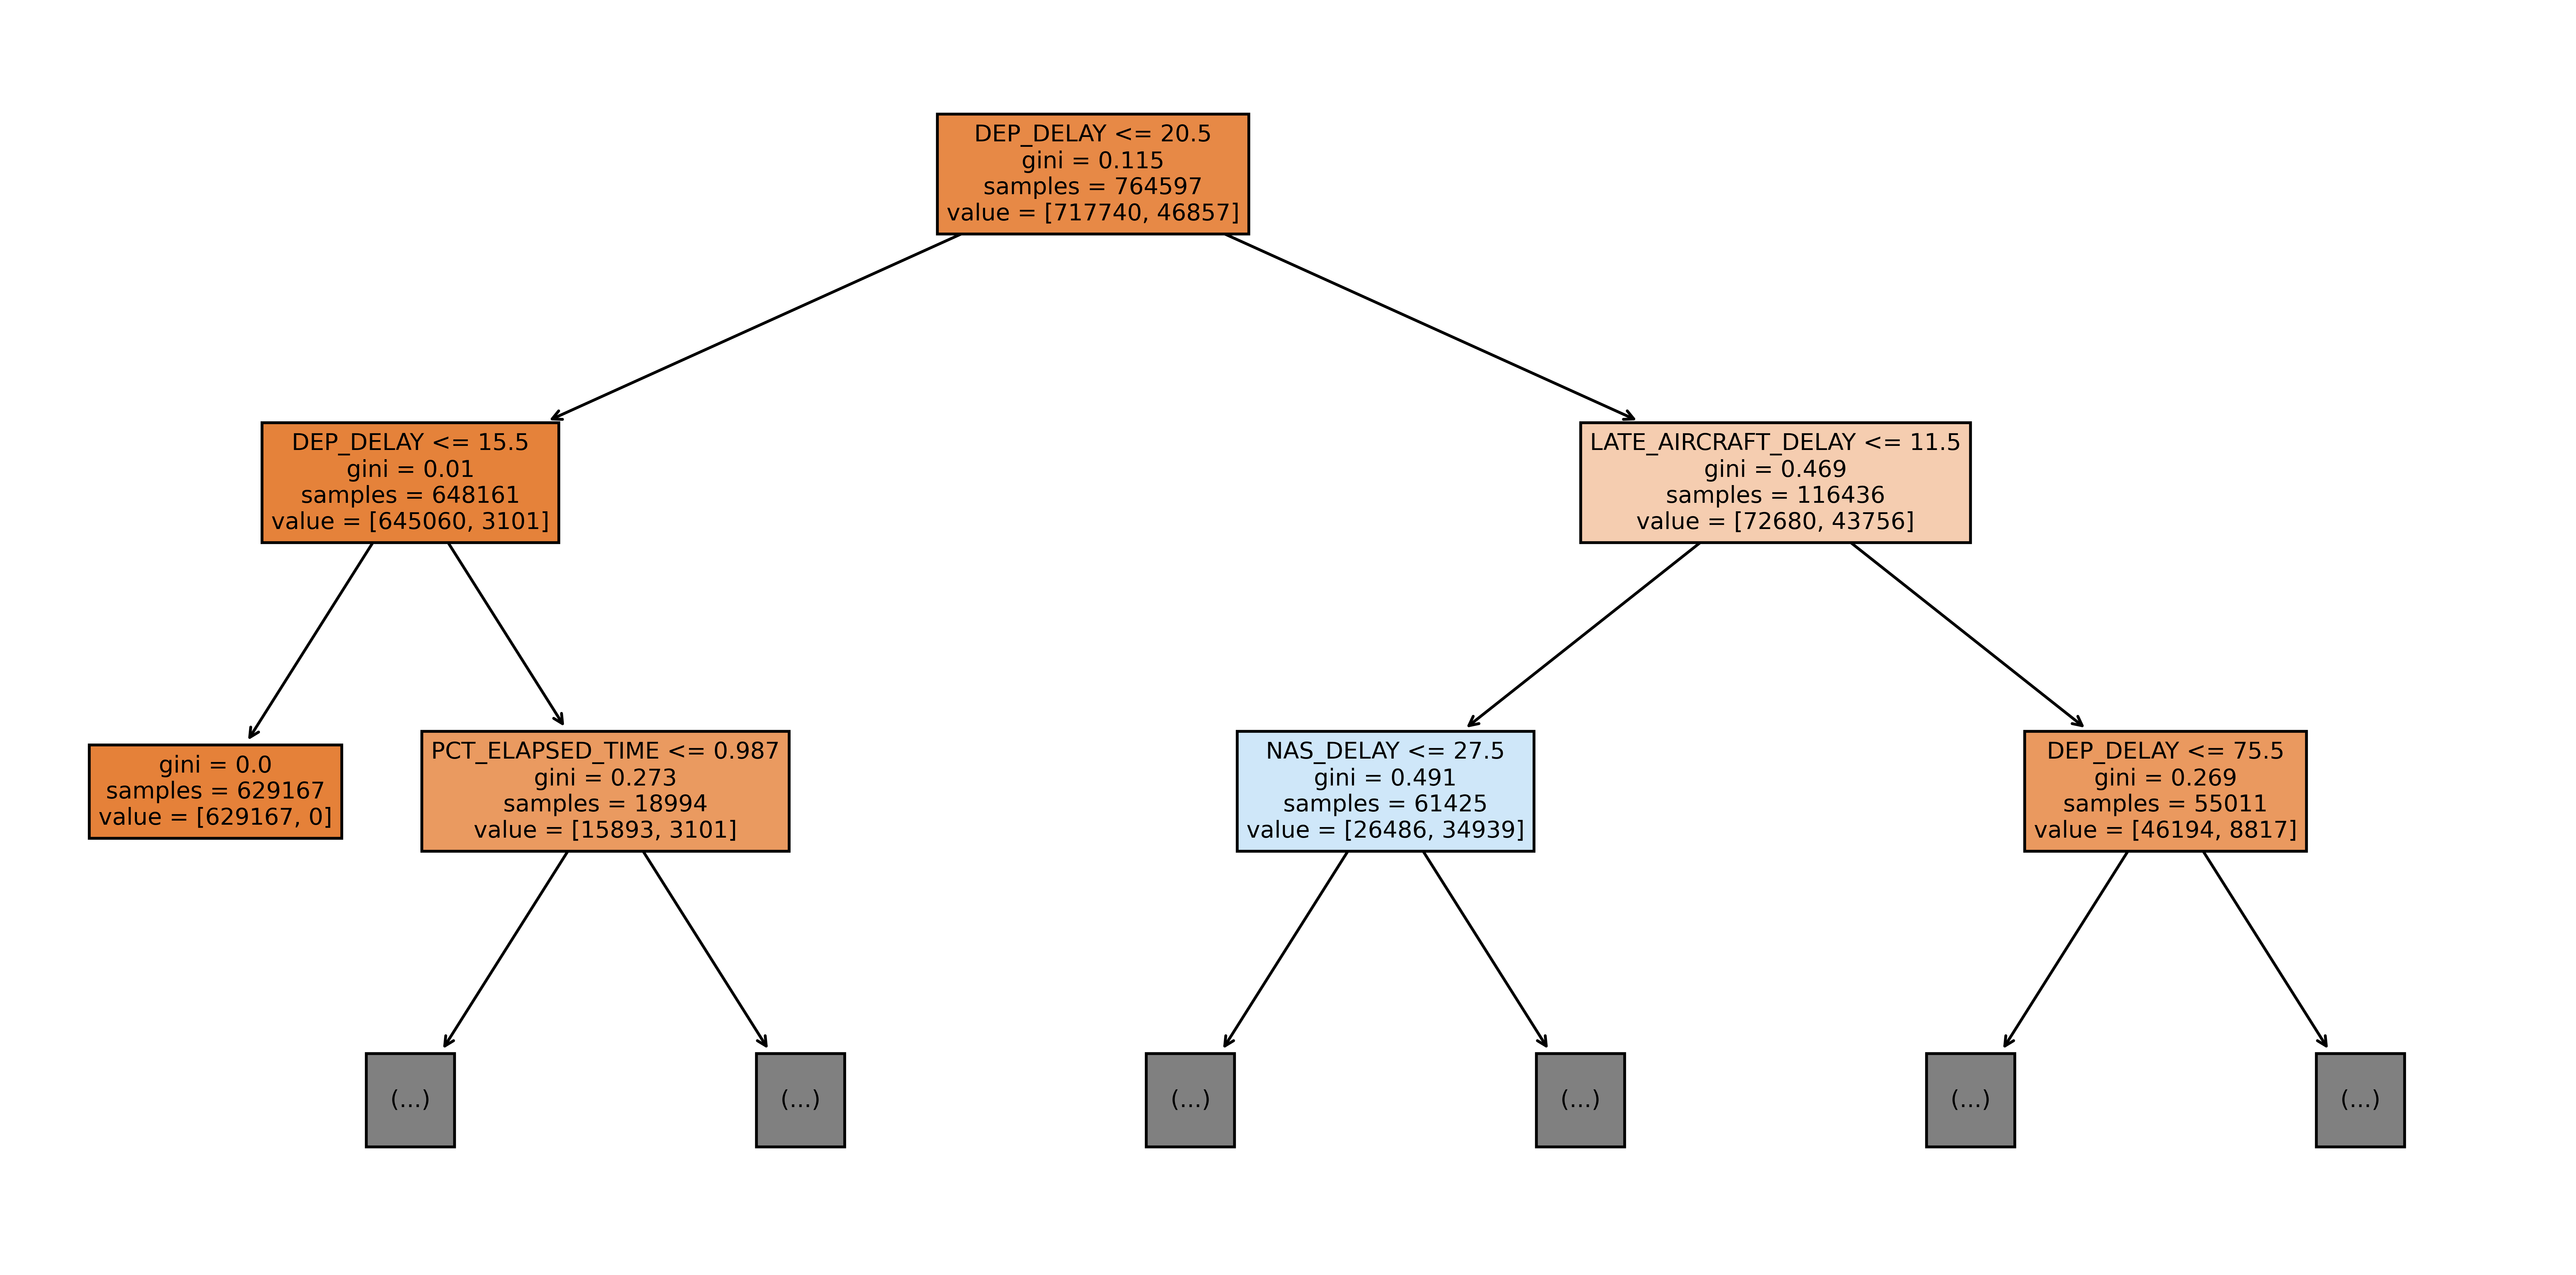

In [45]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8), dpi=600)
tree.plot_tree(class_models['decision_tree']['fitted'],\
               feature_names=X_train.columns.values.tolist(), filled = True, max_depth=2)
fig.show()

##### *Figure 17: Our models' plotted decision tree.*

From the above tree, you can tell that the very first branch splits the decision tree based on the value of `DEP_DELAY` being equal or smaller than $20.5$. It tells you the Gini index that informed that decision and the amount of `samples` (just another way of saying observations, data points, or rows) present. You can traverse these branches till it reaches a leaf. There is one leaf node in this tree, and it is in the far left. This is a classification tree, so you can tell by the `value= [629167, 0]` that all 629,167 samples left in this node have been classified as a $0$ (Not Delayed).

Another way the tree can be better visualized but with fewer details like the Gini index and sample size is printing out the decisions made in every branch and the class in every node:

In [46]:
text_tree = tree.export_text(class_models['decision_tree']['fitted'],\
               feature_names=X_train.columns.values.tolist())
print(text_tree)

|--- DEP_DELAY <= 20.50
|   |--- DEP_DELAY <= 15.50
|   |   |--- class: 0
|   |--- DEP_DELAY >  15.50
|   |   |--- PCT_ELAPSED_TIME <= 0.99
|   |   |   |--- PCT_ELAPSED_TIME <= 0.98
|   |   |   |   |--- PCT_ELAPSED_TIME <= 0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- CRS_ELAPSED_TIME >  65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- PCT_ELAPSED_TIME >  0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 140.50
|   |   |   |   |   |   |--- DEP_DELAY <= 18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- DEP_DELAY >  18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   

There's a lot more that can be done with a decision tree, and the sci-kit learn provides an API to explore the tree.

##### Feature Importance

Calculating feature importance in a CART decision tree is reasonably straightforward. As you can appreciate by the visualizations, some features appear more often in the decisions, but their appearances are weighted by how much they contributed to the overall reduction in the Gini index compared to the previous node. All the sum of the relative decrease in the Gini index throughout the tree is tallied, and the contribution of each feature is a percentage of this reduction.

In [ ]:
dt_imp_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'importance': class_models['decision_tree']['fitted'].feature_importances_}).\
            sort_values(by='importance', ascending=False)
dt_imp_df

![png](./Chapter3_files_extra/Fig_18.png)
##### *Figure 18: Our decision tree's feature importance.*

#### //Interpretation and Domain Expertise//

##### //This last feature importance table increases suspicions about the delay features.  They occupy yet again five of the top six positions. Is it possible that all five of them have such an outsized effect on the model? The target `CARRIER_DELAY` is also called a dependent variable because it's dependent on all the other features, the independent variables. Even though a statistical relationship doesn't imply causation, we want to inform our feature selection based on our understanding of what independent variables could plausibly affect a dependent one. It makes sense that a departure delay (`DEPARTURE_DELAY`) affects the arrival delay (which we removed), and therefore, the `CARRIER_DELAY`. Similarly, `LATE_AIRCRAFT_DELAY` makes sense as a predictor because it is known before the flight takes off if a previous aircraft was several minutes late, causing this flight to be at risk of arriving late, but not as a cause of the current flight (ruling this option out). However, even though the Bureau of Transportation Statistics website [[^4]] defines delays in such a way that they appear to be discrete categories, some may be determined well-after flight has departed. For instance, in predicting a delay mid-flight, could we predict based on `WEATHER_DELAY` if the bad weather hasn't yet happened? And could we predict based on `SECURITY_DELAY` if the security breach hasn't yet occurred? The answers to these questions are that we probably shouldn't because the rationale for including them as they could serve to rule out a `CARRIER_DELAY` but this only works if they are discrete categories that pre-date the dependent variable! Before making further conclusions, what you would need to do is talk to the airline executives to determine the timeline in which each delay category gets consistently set and (hypothetically) are accessible from the cockpit or the airline's command center. Even if you are forced to remove them from the models, maybe other data can fill the void in a meaningful way, such as the first 30 minutes of flight logs and or historical weather patterns. ***Interpretation is not always directly inferred from the data and the machine learning models, but by working closely with domain experts. But sometimes domain experts are entirely wrong too***. In fact, another insight is with all the time-based metrics and categorical features we engineered at the beginning of the chapter (`DEP_RFPH`, `DEP_AFPH`, `ORIGIN_HUB`, etc.). It turns out they have consistently had little to no effect on the models. Despite the airline executives hinting to the importance of hubs and congestion, we should have explored the data further looking for correlations before engineering the data. But even if we do engineer some useless features, it also helps to use a surrogate white-box model to assess their impact, as we have. In data science, the practitioners often will learn the same way the most performant machine learning models do - by trial and error!//

[^4]: Bureau of Transportation Statistics website `https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations#q4` 

### RuleFit

RuleFit is one model-class family that is a hybrid between a LASSO linear regression to get regularized coefficients for every feature and merges this to decision rules, which it also uses LASSO to regularize. These decision rules are extracted by traversing a decision tree finding interaction effects between features, and assigning coefficients to them based on their impact on the model. The implementation used in this chapter uses gradient boosted decision trees to perform this task.

We haven't covered decision rules explicitly in this chapter, but they are yet another family of _inherently interpretable models_. They weren't included because, at the time of the writing, the only Python library that supports decision rules called Bayesian Rule List (BRL) by Skater is still in an experimental stage [[^5]]. In any case, the concept behind decision rules is very similar. It extracts the feature interactions from a decision tree, but it doesn't discard the leaf node, and instead of assigning coefficients, it uses the predictions in the leaf node to construct the rules. The last rule is a catch-all like an _ELSE_ statement. Unlike RuleFit, it can only be understood sequentially because it's so similar to any _IF-THEN-ELSE_ statement, but that's its main advantage.

##### Interpretation & Feature Importance

You can put everything you need to know about RuleFit into a single dataframe (`rulefit_df`). Then you remove the rules that have a coefficient of $0$. It has these because in LASSO, unlike Ridge, coefficient estimates converge to zero. You can sort the dataframe by importance in a descending manner to see what features or feature interactions (in the form of rules) are most important.

In [ ]:
rulefit_df = reg_models['rulefit']['fitted'].get_rules()
rulefit_df = rulefit_df[rulefit_df.coef != 0].sort_values(by="importance", ascending=False)
rulefit_df

![png](./Chapter3_files_extra/Fig_19.png)
##### *Figure 18: RuleFit's rules.*

There's a `type` for every RuleFit feature. Those that are `linear` are interpreted as you would any linear regression coefficient. Those that are `type=rule` are to be treated like binary features in a linear regression model. For instance, if the rule `WEATHER_DELAY > 255.0 & DEP_DELAY > 490.5` is true, then the coefficient `-333.579026` is applied to the prediction. The rules capture the interaction effects, so don't have to add interaction terms to the model manually or use some non-linear method to find them. Furthermore, it does this in an easy to understand manner. You can use RuleFit to guide your understanding of feature interactions even if you choose to productionize other models.

[^5]: Skater python library refernce `https://oracle.github.io/Skater/reference/interpretation.html#bayesian-rule-lists-brl`

### Nearest Neighbors

Nearest neighbors are a family of models that even includes unsupervised methods. All of them use the closeness between data points to inform their predictions. Of all these methods, only the supervised k-Nearest Neighbors, and it's cousin Radius Nearest Neighbors are somewhat interpretable. 

#### k-Nearest Neighbors (kNN)

The idea behind k-Nearest Neighbors is straightforward. It takes the $k$ closest points to a data point in the training data and uses their labels (`y_train`) to inform the predictions. If it's a classification task, it's the _mode_ of all the labels, and if it's a regression task, it's the _mean_. It's a _lazy learner_ because the "fitted model" is not much more than the training data and the parameters such as $k$ and the list of classes (if it's classification). It doesn't do much till inference. That's when it leverages the training data, tapping into it directly rather than extracting parameters, weights/biases, or coefficients learned by the model like _eager learners_ do.

##### Interpretation

k-Nearest Neighbors only has local interpretability because since there's no fitted model, you don't have global modular or global holistic interpretability. For classification tasks, you could attempt to get a sense of this using the decision boundaries and regions we studied in Chapter 2 (_Key Concepts of Interpretability_). Still, it's always based on local instances.

To interpret a local point from our test data set, we query the `pandas` dataframe using its index. We will be using flight #721043:

In [49]:
print(X_test.ix[721043,:])

CRS_DEP_TIME           655.000000
DEP_TIME              1055.000000
DEP_DELAY              240.000000
DEP_AFPH                90.800000
DEP_RFPH                 0.890196
TAXI_OUT                35.000000
WHEELS_OFF            1130.000000
CRS_ELAPSED_TIME       259.000000
PCT_ELAPSED_TIME         1.084942
DISTANCE              1660.000000
CRS_ARR_TIME           914.000000
ARR_AFPH                40.434783
ARR_RFPH                 1.064073
WEATHER_DELAY            0.000000
NAS_DELAY               22.000000
SECURITY_DELAY           0.000000
LATE_AIRCRAFT_DELAY    221.000000
DEP_MONTH               10.000000
DEP_DOW                  4.000000
ORIGIN_HUB               1.000000
DEST_HUB                 0.000000
Name: 721043, dtype: float64


In the `y_test_class` labels for flight #721043 we can tell that it was delayed:

In [50]:
print(y_test_class.ix[721043,:])

1


However, our KNN model predicted that it was not:

In [51]:
print(class_models['knn']['preds'][X_test.index.get_loc(721043)])

0


Please note that the predictions are outputted as a `numpy` array, so we can't access the prediction for flight #721043 using it's `pandas` index ($721043$). We have to use the sequential location of this index in the test dataset using `get_loc` to retrieve it.

To find out why this was the case, we can use `kneighbors` on our model to find the $7$ nearest neighbors of this point. To this end, we have have to `reshape` our data because `kneighbors` will only accept it in the same shape found in the training set, which is $(n, 21)$ where $n$ is the number of observations (rows). In this case, `n=1` because we only want the nearest neighbors for a single data point. And as you can tell by what was outputted by `X_test.ix[721043,:]`, a `pandas` series has a shape of $(21, 1)$, so we have to reverse this shape. 

In [52]:
print(class_models['knn']['fitted'].kneighbors(X_test.ix[721043,:].values.reshape(1,21), 7))

(array([[143.3160128 , 173.90740076, 192.66705727, 211.57109221,
        243.57211853, 259.61593993, 259.77507391]]), array([[105172, 571912,  73409,  89450,  77474, 705972, 706911]]))


`kneighbors` outputs two arrays. The first is the distance of each of the seven closest training points to our test data point. And the second is the location of these data points in the training data.

In [53]:
print(y_train_class.iloc[[105172, 571912,  73409,  89450,  77474, 705972, 706911]])

3813      0
229062    1
283316    0
385831    0
581905    1
726784    1
179364    0
Name: CARRIER_DELAY, dtype: int64


We can tell that the prediction is that the most common class in the seven nearest points was $0$ (Not delayed). You can increase or decrease the $k$ to see if this holds. Incidentally, when using binary classification, it's recommended to choose an odd-numbered $k$ so that there are no ties. Another important aspect is the distance metric that was used to select the closest data points. You can easily find out which one it is using:

In [54]:
print(class_models['knn']['fitted'].effective_metric_)

euclidean


And, for this example, which is for a _real-valued vector space_ because most features are continuous, you could test different distance metrics such as `minkowski`, `seuclidean` or `mahalanobis`.  When most of your features are binary and categorical, you have a _integer valued vector space. So your distances ought to be calculated with algorithms suited for this space such as `hamming` or `canberra`.

##### Feature Importance

Feature importance is, after all, a global model interpretation method and kNN has a hyper-local nature, so there's no way of deriving feature importance from a kNN model. 

### Naïve Bayes

Like GLMs, Naïve Bayes is a family of model classes with a model tailored to different statistical distributions. However, unlike GLM's assumption that the target $y$ feature has the chosen distribution, all Naïve Bayes models assume that your $X$ features have this distribution. More importantly, they were based on _Bayes' theorem of conditional probabilities_, so they output a probability and are, therefore, exclusively classifiers. But they treat the probability of each feature impacting the model independently, which is a strong assumption. This is why they are called naïve. There's one for Bernouilli called _Bernouilli Naïve Bayes_, one for Multinomial called _Multinomial Naïve Bayes_, and, of course, one for Gaussian, which is the most common.

#### Gaussian Naïve Bayes

Bayes theorem is defined by this formula:

$P(A|B) = \frac{P(A|B)P(A)}{P(B)}$

In other words, to find the probability of $A$ happening given that $B$ is true, you take the conditional probability of $B$ given $A$ is true times the probability of $A$ occurring divided by the probability of $B$. In the context of a machine learning classifier, this formula can be rewritten as:

$P(y|X) = \frac{P(X|y) \cdot P(y)}{P(X)}$

Because what we want is the probability of $y$ given $X$ is true. But our $X$ has more than one feature, so this can be expanded like this:

$P(y|x_1,x_2,\text{...}x_{n}) = \frac{P(x_1|y)P(x_2|y)\text{...}P(x_{n}|y) \cdot P(y)}{P(x_1)P(x_2)\text{...}P(x_{n})}$

To compute $\hat{y}$ predictions, we have to consider that we have to calculate and compare probabilities for each $C_k$ class (the probability of a delay vs. the probability a not delay) and choose the class with the highest probability:

$\hat{y} = P(y|X) = \underset{C_k}{\mathrm{argmax}} P(y=C_k) \prod_{i=1}^n P(x_i|y=C_k)$

Calculating the probability of each class $P(y=C_k)$ (also known as class prior) is relatively trivial. In fact, the fitted model has stored this in an attribute called `class_prior_`.

In [55]:
print(class_models['naive_bayes']['fitted'].class_prior_)

[0.93871674 0.06128326]


Naturally, since delays caused by the carrier only occur 6% of the time, this is the marginal probability of this occurring. 

Then the formula has a product $\prod_{i=1}^n$ of conditional probabilities that each features belonging to a class $P(x_i|y=C_k)$. Since this is binary there's no need to calculate the probabilities of multiple classes because they are inversely proportional. Therefore we can drop the $C_k$ and replace it with a $1$ like this:

$\hat{y} = P(y=1|X) = P(y=1) \prod_{i=1}^n P(x_i|y=1)$

Because what we are trying to predict is the probability of a delay. Also, $P(x_i|y=1)$ is its own formula which differs according to the assumed distribition of the model, in this case gaussian:

$P(x_i|y=1) = \frac{1}{\sqrt{2 \pi \sigma_i^2}} e^{- \frac{(x_i - \theta_i)^2}{2 \sigma_i^2}}$

This formula is called the probability density of the gaussian distribution.

##### Interpretation and Feature Importance

So what are these sigmas ($\sigma_i$) and thetas ($\theta_i$) in the formula? They are, respectively, the variance and mean of the $x_i$ feature when `y=1`. The intuition behind this is that features have different variance and mean in one class versus the other, which can inform the classification. This is a binary classification task, but you could calculate $\sigma_i$ and $\theta_i$ for both classes. Fortunately, the fitted model has this stored:

In [56]:
print(class_models['naive_bayes']['fitted'].sigma_)

[[2.50123026e+05 2.61324730e+05 9.21572605e+02 1.26123968e+03
  2.08339528e-01 9.58074414e+01 2.62606651e+05 6.30102550e+03
  1.13475535e-02 4.22470414e+05 2.75433641e+05 1.25314386e+03
  3.48655340e-01 1.11234714e+02 1.91877186e+02 2.80302201e+00
  5.06561612e+02 1.17346654e+01 3.99122491e+00 2.39015406e-01
  2.34996222e-01]
 [2.60629652e+05 2.96009867e+05 1.19307931e+04 1.14839167e+03
  1.99929921e+00 1.20404927e+02 3.08568277e+05 6.29066219e+03
  1.38936741e-02 4.10198938e+05 3.28574000e+05 1.09023147e+03
  3.08997044e+00 7.79140423e+01 1.56184090e+02 9.12112286e-01
  2.11279954e+03 1.02712368e+01 4.02943162e+00 1.77750796e-01
  2.50208354e-01]]


!!!There are two arrays here, the first one corresponding to the negative class and the second to the positive. The arrays contain the sigmas (variance) for each of the 21 features given the class. You can also extract the thetas (means) from the model:!!!

In [57]:
print(class_models['naive_bayes']['fitted'].theta_)

[[1.30740577e+03 1.31006271e+03 5.14196506e+00 5.45864877e+01
  1.09377996e+00 1.87120810e+01 1.33552258e+03 1.70734929e+02
  9.71131781e-01 1.01824369e+03 1.48438931e+03 5.39873058e+01
  1.09644787e+00 7.39971299e-01 2.85434558e+00 2.41814585e-02
  4.14674395e+00 6.55045281e+00 2.95035528e+00 6.06800513e-01
  6.24199571e-01]
 [1.41305545e+03 1.48087887e+03 8.45867640e+01 6.14731036e+01
  1.25429654e+00 1.99378321e+01 1.49409412e+03 1.72229998e+02
  9.83974416e-01 1.04363666e+03 1.54821862e+03 4.26486417e+01
  1.36373798e+00 4.50733082e-01 4.71991378e+00 2.11281132e-02
  1.40744819e+01 6.73367907e+00 3.04251232e+00 7.69575517e-01
  4.85391724e-01]]


These two arrays are all you need to debug and interpret Naïve Bayes results because you can use them to compute the conditional probability that $x_i$ feature given a positive class $P(x_i|y=1)$. You could use this probability to rank the features by importance on a global level or interpret a specific prediction, on a local level.

Naïve Bayes is a fast algorithm with some good use cases such as spam filtering and recommendation systems, but the independence assumption hinders its performance for most situations. Speaking of performance, let's discuss this topic in the context of interpretability.

## Performance vs Interpretability Trade-off

We have briefly touched on this topic before, but high performance often requires complexity, and complexity inhibits interpretability. As studied in Chapter 2 (_Key Concepts of Interpretability_), this complexity comes from primarily three sources: non-linearity, non-monotonicity, and interactivity. If the model adds any complexity, it is ***compounded by the number and nature of features*** in your dataset, which by itself is a source of complexity.

### Special Model Properties

These special properties can help make a model more interpretable.

#### The Key 🔑 Property: Explainability

In Chapter 1 (_Interpretation_, _Interpretability_ and _Explainability; and why does it all matter?_) we discussed why being able to look under the hood of the model and intuitively understand how all it's moving parts derive its predictions in a consistent manner is, mostly, what separates _Explainability_ from _Interpretability_. This property is also called _transparency_ or _translucency_. A model can be interpretable without this, but in the same way, we can interpret a person's decisions because we can't understand what is going on "under the hood." This is often called _Post-hoc Interpretability_ and this is the kind of interpretability this book primarily focusses on, with a few exceptions. That being said, we ought to recognize that if a model is understood by leveraging it's mathematical formula (grounded in statistical and probability theory) like we've done with Linear Regression and Naïve Bayes, or by visualizing a human-interpretable structure like with decision trees, or a set of rules like with RuleFit, it is much more interpretable than machine learning model classes where none of this is practically possible. White box models always will have the upper hand in this regard, and as listed in Chapter 1, there are many use cases in which a white-box model is a must-have. But even if you don't productionize white-box models, they can always serve a purpose in assisting with interpretation, if data dimensionality allows. It is a key property because it wouldn't matter if it didn't comply with the other properties as long as it had explainability; it would still be more interpretable than those without it.

#### The Remedial 🔧 Property: Regularization

In this chapter, we've learned that _regularization_ tones down complexity added by the introduction of too many features, and this can make the model more interpretable, not to mention more performant. Some models incorporate regularization into the training algorithm such as RuleFit and Gradient Boosted Trees; others have to ability to integrate it like Multi-layer perceptron, or Linear Regression, and some cannot include it like k-Nearest Neighbors. Regularization comes in many forms. Decision trees have a method called pruning, which can help reduce complexity by removing non-significant branches. Neural networks have a technique called drop-out, which randomly drops neural network nodes from layers during training. Regularization is a remedial property because it can help even the least interpretable models improve.

### Assesing Performance

By now, in this chapter, you have already assessed performance on all of the white-box models reviewed in the last section as well as a few black-box models. Maybe you've already noticed that black-box models have topped most metrics, and for most use cases, this is generally the case.

Figuring out which model classes are more interpretable is not an exact science, but the table below is sorted by those models with the most desirable properties. That is, they don't introduce non-linearity, non-monotonicity, and interactivity. Of course, explainability on its own is a property that is a game-changer, regardless, and regularization can help. There are also cases in which it's hard to assess properties. For instance, polynomial (linear) regression implements a linear model, but it fits nonlinear relationships, which is why it is color-coded differently. As you will learn in Chapter 12 (_Monotonic Constraints and Model Tuning for Interpretability_) some libraries support adding monotonic constraints to Gradient Boosted Trees and Neural Networks, which means it's possible to make these monotones. However, the black-box methods we used in this chapter do not support monotonic constraints.

The task columns tell you if they can be used for regression or classification. And the Performance Rank columns show you how well these models ranked in RMSE (for regression) and ROC AUC (for classification), where lower ranks are better. Please note that even though we have used only one metric to assess performance for this chart for simplicity's sake, discussion about performance should be more nuanced than that. Another thing to note is that Ridge Regression did poorly, but this is because we used the wrong hyperparameters, as explained in the previous section.

![png](./Chapter3_files_extra/Fig_20.png)
##### *Figure 20: A table assesing the interpretability and performance of several white-hat and black-box models.*

Because it's compliant on all three main properties, it's easy to tell why linear regression is the gold standard for interpretability. Also, while recognizing that this is anecdotal evidence, it should be immediately apparent that most of the best ranks are with black-box models. This is no accident! The math behind neural networks and gradient boosted trees is brutally efficient in achieving the best metrics. Still, as the red dots suggest, they have all the properties that make a model less interpretable, making their biggest strength and complexity a potential weakness. This is precisely why black-box models are our primary interest in this book, although many of the methods you will learn to apply to white-box models. In Part 2, which comprises Chapters 4 through 9, we will learn model-agnostic and deep-learning-specific methods that assist with interpretation. And in Part 3, which includes Chapters 10 through 14, we will learn how to tune models and datasets to increase interpretability. 

#### //Interpretation and Execution Speed//

##### //Predictive performance is not the only kind of performance to watch out for. When we have discussed performance so far in this book, we have not directly addressed the importance of _execution speed_ (also called _computation time_). Predictive performance is, generally, inversely proportional to both interpretability and execution speed. Just as black-box models tend to predict better, white-box models are more interpretable and faster than black-box models. Often not only in training but also in the inference. This problem used to be a significant deterrent. Even though deep learning methods have existed for over a half a century, they only really took off till a decade ago because of resource constraints! So why is it still relevant? Because data scientists, data engineers, and machine learning engineers are continually pushing the boundaries by increasing the complexity of their models, the size of datasets, and the use of hyperparameter tuning to improve predictive performance. They thus require more resources to train and possibly make them quick at inference. However, a model that has slow inference is not practical for many use-cases because it might not be cost-effective or requires real-time inference, which it would have too much latency to achieve. Therefore, there is a trade-off between predictive performance and execution performance. And while AI researchers push the boundaries for model interpretability, there will be cases where trade-offs between all three are considered: predictive performance, execution speed performance, and interpretability. Higher interpretability, while retaining high predictive performance, might come with a significant loss in execution speed performance. Such is the case for the glass-box models we are reviewing in the next section, but who knows? Someday we might have our cake and eat it too!//

![png](./Chapter3_files_extra/Fig_21.png)
##### *Figure 21: A table comparing White-Box, Black-Box and Glass-Box models, or at least what is known so far about them.*

## Newer Interpretable Models (Glass-box)

Recently, there are significant efforts in both industry as well as in academia to create new models that can have enough complexity to find the sweet spot between underfitting and overfitting, known as the _Bias–Variance Trade-off_, but retain an adequate level of explainability.

Many models fit this description, but most of them are meant for specific use cases, haven't been properly tested yet, or have released a library or open-sourced the code. However, two general-purpose ones are already gaining traction:

### Explainable Boosting Machine (EBM)

Explainable Boosting Machines are part of Microsoft's InterpretML [[^6]] framework, which includes many of the model-agnostic methods we will use later in the book. 

EBM leverages the Generalized Additive Models (GAM)s [[^7]] we mentioned earlier, which are like linear models but look like this:

$\hat{y} = g(E[y]) = \beta_0 + f_1(x_1) + f_2(x_2) + \text{...} + f_j(x_j)$

Individual functions $f_1$ through $f_p$ are fitted to each feature using spline functions. Then a link function $g$ adapts the GAM to perform different tasks such as classification or regression, or adjust predictions to different statistical distributions. GAMs are white-box models, so what makes EBM a glass-box model? It incorporates bagging and gradient boosting, which tend to make models more performant. The boosting is done one feature at a time using a low learning rate not to confound them. It also finds practical interaction terms automatically, which improves performance while maintaining interpretability:

$\hat{y} = g(E[y]) = \beta_0 + \sum f_j(x_j) + \sum f_{ji}(x_j, x_i)$

Once fitted, this formula is made up of complicated non-linear formulas, so a global holistic interpretation isn't likely feasible. However, since the effects of each feature or pairwise interaction terms are additive, they are easily separable, global modular interpretation is entirely possible. Local interpretation is equally easy given that a mathematical formula can assist in debugging any prediction. 

One drawback is that EBM can be much slower than gradient boosted trees and neural networks because of the one feature at a time approach, low learning rate not impacting feature order, and spline fitting methods. However, it is parallelizable, so in environments with ample resources and multiple cores or machines, it will be much quicker. To not have you wait for results for an hour or two, it is best to use the same technique for dimensionality reduction using the abbreviated versions of `X_train` and `X_test`. However, this time we will only used the eight features white-box models found to be most important: `DEP_DELAY`, `LATE_AIRCRAFT_DELAY`, `PCT_ELAPSED_TIME`, `WEATHER_DELAY`, `NAS_DELAY`, `SECURITY_DELAY`, `DISTANCE`, `CRS_ELAPSED_TIME` and `TAXI_OUT`. These are placed in a `feature_samp` array, and then `X_train` and `X_test` dataframes are subset to only include this feature. We are setting the `sample2_size` to 10%, but if you feel you have enough resources to handle it, adjust accordingly.

In [58]:
#Make new abbreviated versions of datasets
feature_samp = ['DEP_DELAY', 'LATE_AIRCRAFT_DELAY', 'PCT_ELAPSED_TIME', 'WEATHER_DELAY',\
                'NAS_DELAY', 'SECURITY_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME']
X_train_abbrev2 = X_train[feature_samp]
X_test_abbrev2 = X_test[feature_samp]
#For sampling among observations
np.random.seed(rand)
sample2_size = 0.1
sample2_idx = np.random.choice(X_train.shape[0], math.ceil(X_train.shape[0]*sample2_size), replace=False)

To train your EBM, all you have to do is instantiate an `ExplainableBoostingClassifier()` and then fit your model to your training data. Just as we did with dimensionality reduction, we are using `sample2_idx` to sample a portion of the data. 

In [59]:
ebm_mdl = ExplainableBoostingClassifier()
ebm_mdl.fit(X_train_abbrev2.iloc[sample2_idx], y_train_class.iloc[sample2_idx])

ExplainableBoostingClassifier(feature_names=['DEP_DELAY', 'LATE_AIRCRAFT_DELAY',
                                             'PCT_ELAPSED_TIME',
                                             'WEATHER_DELAY', 'NAS_DELAY',
                                             'SECURITY_DELAY', 'DISTANCE',
                                             'CRS_ELAPSED_TIME'],
                              feature_types=['continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous'])

#### Global Interpretation

Global interpretation is dead simple. It comes with an `explain_global` dashboard you can explore. It loads with the feature importance plot first, and you can select individual features to graph what was learned from each one.

In [ ]:
show(ebm_mdl.explain_global())

![png](./Chapter3_files_extra/Fig_22.png)
##### *Figure 22: EBM's global interpretation dashboard.*

#### Local Interpretation

Uses a dashboard like global does except you choose specific predictions to interpret with `explain_local`. In this case, we are selecting #76, which, as you can tell, was incorrectly predicted. But the LIME-like plot we will study in Chapter 6 (_Local Model Agnostic Interpretation Methods_) helps make sense of it.

In [ ]:
ebm_lcl = ebm_mdl.explain_local(X_test_abbrev2.iloc[76:77],\
                                y_test_class[76:77], name='EBM')
show(ebm_lcl)

![png](./Chapter3_files_extra/Fig_23.png)
##### *Figure 23: EBM's local interpretation dashboard.*

#### Performance

Performance, at least measured with the ROC AUC, EBM is not far from what was achieved by the top two classification models, and we can only expect it to get better with ten times more training and testing data!

In [ ]:
ebm_perf = ROC(ebm_mdl.predict_proba).\
                            explain_perf(X_test_abbrev2.iloc[sample_idx],\
                                         y_test_class.iloc[sample_idx], name='EBM')
show(ebm_perf)

![png](./Chapter3_files_extra/Fig_24.png)
##### *Figure 24: One of EBM's performance dashboard.*

The performance dashboard can also compare several models at a time since its explainers are model-agnostic. And there's even a fourth dashboard that can be used for data exploration.

[^6]: Nori, H., Jenkins, S., Koch, P., & Caruana, R. (2019). Interpretml: A unified framework for machine learning interpretability. arXiv preprint `https://arxiv.org/pdf/1909.09223.pdf`

[^7]: Hastie, T and Tibshirani, R. Generalized additive models: some applications. Journal of the American Statistical Association, 82(398):371–386, 1987. `http://doi.org/10.2307%2F2289439`

### Skoped Rules

For Skoped Rules [[^8]], rules are extracted from an ensemble of trees just like it's done with RuleFit, and L1-regularization (_LASSO_) is also applied. However, it uses Random Forest instead of Gradient Boosted Trees and doesn't incorporate linear regression coefficients. Instead, it only uses the binary rules but they are only applied if precision and recall conditions are held true, and weights are proportional to the OOB (out of bag score) used in Random Forest. By the way, OOB is like validation accuracy, but using a randomly selected subset of decision trees. Because of its focus on precision and recall, Skoped Rules can be great for imbalanced datasets while retaining interpretability.

To fit the model, instantiate `SkopeRules` and `fit` the model to the training data. We are using the same `sample2_idx` used with EBM because it can also get slow but not quite as much. Thankfully, `n_jobs=-1` tells it to leverage all your processor cores. Several parameters can impact performance: `n_estimators` is the number of decision trees, and `max_depth` is the depth of the tree. At the same time `precision_min` and `recall_min` are the minimum amount of precision and recall for a rule to be selected. `random_state` is just right to add for reproducibility. Same as with EBM, this model training snippet of code can take a few minutes.

In [63]:
sr_mdl = SkopeRules(n_estimators=200, precision_min=0.2, recall_min=0.01,\
                    n_jobs=-1, random_state=rand, max_depth=7,\
                    feature_names=X_train_abbrev2.columns)
sr_mdl.fit(X_train_abbrev2.iloc[sample2_idx], y_train_class.iloc[sample2_idx])

SkopeRules(feature_names=Index(['DEP_DELAY', 'LATE_AIRCRAFT_DELAY', 'PCT_ELAPSED_TIME', 'WEATHER_DELAY',
       'NAS_DELAY', 'SECURITY_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME'],
      dtype='object'),
           max_depth=7, n_estimators=200, n_jobs=-1, precision_min=0.2,
           random_state=9)

In the following code, the probability each flight is delayed is returned by `score_top_rules`, and this, in turn, can be used to create the predictions using `np.where` with the threshold set at $0.5$.

In [64]:
sr_y_test_prob = sr_mdl.score_top_rules(X_test_abbrev2.iloc[sample_idx])
sr_y_test_pred = np.where(sr_y_test_prob > 0.5, 1, 0)

#### Global Interpretation

The `rules_` attribute has a list of tuples with each rules. As you can tell, there are 1517 rules generated but because of the way algorithm uses precion and recall, rules are not always considered. This makes inference slower. The rules are sorted by how well they perform.

In [65]:
print(len(sr_mdl.rules_))

1493


Let's look at the five most performing rules generated:

In [66]:
print(sr_mdl.rules_[0:5])

[('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 12.5 and WEATHER_DELAY <= 12.0 and NAS_DELAY <= 29.5 and SECURITY_DELAY <= 8.5', (0.9585547290116897, 0.4800425758382118, 2)), ('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 11.5 and WEATHER_DELAY <= 12.5 and NAS_DELAY <= 27.5 and SECURITY_DELAY <= 8.5', (0.9608998393144081, 0.47586206896551725, 2)), ('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 12.5 and WEATHER_DELAY <= 12.0 and NAS_DELAY <= 27.5 and SECURITY_DELAY <= 16.5', (0.9579037047855509, 0.47316836019772934, 4)), ('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 11.5 and WEATHER_DELAY <= 12.0 and NAS_DELAY <= 27.5 and SECURITY_DELAY <= 16.5', (0.9602813485868389, 0.4706939497340879, 32)), ('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 11.5 and WEATHER_DELAY <= 12.5 and NAS_DELAY <= 29.5 and SECURITY_DELAY <= 16.5', (0.9568034557235421, 0.4715274081958489, 2))]


As you go down the list, you can start understanding what matters the most to the model as singular IF statements that, if true, indicate a positive class.

#### Local Interpretation

Let's examine one model-specific local prediction method. The prediction for 76th flight was not delayed even though this flight was delayed:

In [67]:
print('actual: %s, predicted: %s' % (y_test_class.iloc[76], sr_y_test_pred[76]))

actual: 1, predicted: 0


We can tell why with the decision function that tells you the anomaly score for the input sample. This score is the weighted sum of the binary rules, where each weight is the precision of each rule. So the lower the score, the more likely it is a positive match, and if it's null it's a definite positive match.

In [68]:
print(sr_mdl.decision_function(X_test_abbrev2.iloc[76:77]))

[18.46755085]


#### Performance

Performance was not bad considering it was trained on 10% of the training data, and evaluated on only 10% of the test data. Especially the recall score which was among the top three places.

In [69]:
print('accuracy: %.3g, recall: %.3g, roc auc: %.3g, f1: %.3g, mcc: %.3g' %\
      (metrics.accuracy_score(y_test_class.iloc[sample_idx], sr_y_test_pred),\
       metrics.recall_score(y_test_class.iloc[sample_idx], sr_y_test_pred),\
       metrics.roc_auc_score(y_test_class.iloc[sample_idx], sr_y_test_prob),\
       metrics.f1_score(y_test_class.iloc[sample_idx], sr_y_test_pred),\
       metrics.matthews_corrcoef(y_test_class.iloc[sample_idx], sr_y_test_pred)))

accuracy: 0.96, recall: 0.979, roc auc: 0.983, f1: 0.745, mcc: 0.75


[^8]: SkopedRules documentation `https://skope-rules.readthedocs.io/en/latest/index.html`

## Key Learning Points

Now what do we take away from this chapter? In this chapter, we have learned the following:

- How to **train and evaluate regression models** for Linear Regression, Polynomial Regression, Ridge Regression, Decision Tree, RuleFit, k-Nearest Neighbors, Random Forest, and Multi-Layer Perceptron.
- What are the **regression metrics** Root Mean Squared Error and R-squared, and how to interpret them.
- How to **train and evaluate classification models** for Logistic Regression, Ridge Classification, Decision Tree, k-Nearest Neighbors, Naïve Bayes, Gradient Boosting Trees, Random Forest, and Multi-Layer Perceptron.
- What are the **classification metrics** Accuracy, Recall, Precision, ROC-AUC, F1-score, and MCC, and how to interpret them.
- How to use **dimensionality reduction methods** PCA, t-SNE, and VAE, and what are a few ways they can be leveraged to make sense of your data and classification results.
- _Challenge_: Why **traditional model interpretation methods** only cover surface-level questions about your models.
- How to **understand and interpret white-box models** of Linear Regression, Ridge Regression, Polynomial Regression, Logistic Regression, CART Decision Tree, RuleFit, k-Nearest Neighbors, and Naïve Bayes.
- _Challenge_: Why is it important to **choose your hyperparameter values correctly** so that regularization can have it's intended effect.
- _Challenge_: Why is it important to work closely with **domain experts to inform decisions** in feature selection and engineering, and even model selection, but sometimes they can also be wrong. 
- _Challenge_: What is the **Performance vs. Interpretability Trade-Off**.
- _Challenge_: Why is **Execution Speed Performance** also important.
- How to **understand and interpret glass-box models** EBM and Skoped Rules. 

## Summary

After reading this chapter, you should understand some traditional methods for interpretability and what their limitations are. You learned about  _Inherently Interpretable Models_ and how to both use them and interpret them, for both regression and classification. You also studied the _Performance vs. Interpretability Trade-off_ and some models that attempt not to compromise in this trade-off. You also discovered a couple of practical interpretation challenges involving the roles of hyperparameters, domain experts and execution speed.  In the next chapter, we will learn more about different interpretation methods to measure the effect of a feature on a model.

## References